# Step 1 Data Preprocessing
### in this step, we are loading the dataset; combine them, clean them, then conducat a overview analysis to better understand the dataset
## Step 1.1 - Imports & Display config

In [2]:
# STEP 1.1 — Imports & display config
import os, glob, ast
import numpy as np
import pandas as pd

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 160)

## Step 1.2 - Configure Data Paths

In [3]:
# STEP 1.2 — Configure paths
DATA_DIR = "./Data"   # <-- change to your folder if needed, e.g., "./data"
PATTERN = os.path.join(DATA_DIR, "*.csv")

csv_paths = sorted(glob.glob(PATTERN))
print(f"[INFO] Found {len(csv_paths)} CSV file(s).")
for p in csv_paths[:10]:
    print("   -", os.path.basename(p))
if len(csv_paths) == 0:
    raise FileNotFoundError("No CSV files found. Check DATA_DIR and PATTERN.")

[INFO] Found 423 CSV file(s).
   - default_20240703.csv
   - default_20240704.csv
   - default_20240705.csv
   - default_20240706.csv
   - default_20240707.csv
   - default_20240708.csv
   - default_20240709.csv
   - default_20240710.csv
   - default_20240711.csv
   - default_20240712.csv


## Step 1.3 - Helpers to preprocess the dataset

In [4]:
# STEP 1.3 — Helpers

def parse_duration_text(x: str) -> float:
    """Parse durationText like '24:12' or '1:02:15' into seconds. Returns np.nan on failure."""
    if not isinstance(x, str) or not x.strip():
        return np.nan
    parts = x.strip().split(":")
    try:
        parts = [int(p) for p in parts]
    except ValueError:
        return np.nan
    if len(parts) == 3:  # H:M:S
        h, m, s = parts
        return h*3600 + m*60 + s
    if len(parts) == 2:  # M:S
        m, s = parts
        return m*60 + s
    if len(parts) == 1:  # SS
        return float(parts[0])
    return np.nan

PREFERRED_THUMB_ORDER = ["maxres", "standard", "high", "medium", "default"]

def pick_best_thumbnail(thumbnails_cell):
    """
    thumbnails column often looks like a JSON-like list of dicts as a string.
    We'll try ast.literal_eval and pick the first available by quality preference.
    Returns URL or np.nan.
    """
    if isinstance(thumbnails_cell, list):
        candidates = thumbnails_cell
    elif isinstance(thumbnails_cell, str):
        try:
            candidates = ast.literal_eval(thumbnails_cell)
        except Exception:
            return np.nan
    else:
        return np.nan

    by_quality = {d.get("quality"): d.get("url") for d in candidates if isinstance(d, dict)}
    for q in PREFERRED_THUMB_ORDER:
        if q in by_quality and by_quality[q]:
            return by_quality[q]
    # fallback to first with a url
    for d in candidates:
        if isinstance(d, dict) and d.get("url"):
            return d["url"]
    return np.nan


## Step 1.4 -Load & combine all CSVs to a Master file for further processing

In [5]:
# STEP 1.4 — Load & combine all CSVs to a Master file for further processing
dfs = []
for path in csv_paths:
    try:
        df_i = pd.read_csv(path)
        df_i["__source_file"] = os.path.basename(path)
        dfs.append(df_i)
    except Exception as e:
        print(f"[WARN] Skipping {path} due to error: {e}")

if not dfs:
    raise RuntimeError("No CSVs could be read.")
raw = pd.concat(dfs, ignore_index=True, sort=False)

print(f"[INFO] Combined shape BEFORE cleaning: {raw.shape}")

# --- Normalize core fields if present ---
df = raw.copy()

# Dates
if "publishedDate" in df.columns:
    df["published_at"] = pd.to_datetime(df["publishedDate"], errors="coerce", utc=True)
else:
    df["published_at"] = pd.NaT

df["publish_date"] = df["published_at"].dt.date
df["publish_hour"] = df["published_at"].dt.hour
df["publish_dow"]  = df["published_at"].dt.day_name()

# Integers/numbers
if "views" in df.columns:
    df["views"] = pd.to_numeric(df["views"], errors="coerce")

# Duration in seconds (prefer numeric 'duration', else parse 'durationText')
if "duration" in df.columns:
    dur_numeric = pd.to_numeric(df["duration"], errors="coerce")
else:
    dur_numeric = np.nan
df["duration_sec"] = dur_numeric
if "durationText" in df.columns:
    needs_fill = df["duration_sec"].isna()
    df.loc[needs_fill, "duration_sec"] = df.loc[needs_fill, "durationText"].apply(parse_duration_text)

# Booleans that might be strings
for col in ["verified", "creatorOnRise", "isShort"]:
    if col in df.columns:
        df[col] = df[col].map(
            {True: True, False: False, "True": True, "False": False, "true": True, "false": False}
        )

# Thumbnails: pick a single best URL
if "thumbnails" in df.columns:
    df["thumbnail_url"] = df["thumbnails"].apply(pick_best_thumbnail)
else:
    df["thumbnail_url"] = np.nan

# Dedupe — keep latest record per videoId based on published_at when available,
# otherwise keep the first occurrence
before = len(df)
if "videoId" in df.columns:
    # If we have publish times, keep the most recent row for each video
    if df["published_at"].notna().any():
        df = df.sort_values(["videoId", "published_at"]).drop_duplicates(subset=["videoId"], keep="last")
    else:
        df = df.drop_duplicates(subset=["videoId"], keep="first")
else:
    # Fallback to videoUrl if no videoId
    if "videoUrl" in df.columns:
        df = df.drop_duplicates(subset=["videoUrl"], keep="first")
after = len(df)
print(f"[INFO] Duplicates removed: {before - after} (final rows: {after})")

# Save a master CSV for later steps
MASTER_PATH = os.path.join(DATA_DIR, "youtube_master.csv")
df.to_csv(MASTER_PATH, index=False)
print(f"[INFO] Saved master dataset to: {MASTER_PATH}")


[INFO] Combined shape BEFORE cleaning: (67223, 26)


C:\Users\akato\AppData\Local\Temp\ipykernel_17212\2590971045.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[needs_fill, "duration_sec"] = df.loc[needs_fill, "durationText"].apply(parse_duration_text)


[INFO] Duplicates removed: 54205 (final rows: 13018)
[INFO] Saved master dataset to: ./Data\youtube_master.csv


In [6]:
import pandas as pd
df = pd.read_csv(MASTER_PATH)
df.head()

,title,description,publishedDate,publishedText,videoId,videoUrl,channelName,channelId,channelUrl,thumbnails,views,viewsText,duration,durationText,verified,creatorOnRise,isShort,__source_file,published_at,publish_date,publish_hour,publish_dow,duration_sec,thumbnail_url,extreme_views,extreme_duration
0,Concerning the Stranded Astronauts,Go to https://ground.news/startalk to stay ful...,2024-08-31T15:12:02.989Z,2 days ago,-019XzLfn1s,https://youtube.com/watch?v=-019XzLfn1s,StarTalk,UCqoAEDirJPjEUFcF2FklnBA,https://youtube.com/@StarTalk,"[{'quality': 'maxres', 'url': 'https://i.ytimg...",856882.0,"856,882 views",807,13:27,True,False,False,youtube_master.csv,2024-08-31 15:12:02.989000+00:00,2024-08-31,15,Saturday,807,https://i.ytimg.com/vi/-019XzLfn1s/maxres.jpg,NaN,NaN
1,FEEDING STARVING CELEBRITIES FT. MADELINE ARGY,I cook fish and chips with english royalty,2025-01-05T20:00:08.047Z,6 days ago,-0Ai_f6_DVM,https://www.youtube.com/watch?v=-0Ai_f6_DVM,Quenlin Blackwell,UCRE2zmVNW9wG2dndMoV4JKQ,https://www.youtube.com/@QUENBLACKWELL,"[{'quality': 'maxres', 'url': 'https://i.ytimg...",1901901.0,"1,901,901 views",3349,55:49,True,NaN,False,youtube_master.csv,2025-01-05 20:00:08.047000+00:00,2025-01-05,20,Sunday,3349,https://i.ytimg.com/vi/-0Ai_f6_DVM/maxres.jpg,NaN,NaN
2,Can You Beat my 200m Time 🔥,NaN,2025-05-16T20:12:40.491Z,3 weeks ago,-0FXAQSsmj0,https://www.youtube.com/watch?v=-0FXAQSsmj0,Twin Athletics LA,UC8h9se9Ifr1Bw6H6OUNFpzA,https://www.youtube.com/@TwinAthleticsLA,"[{'quality': 'maxres', 'url': 'https://i.ytimg...",0.0,NaN,-1,SHORTS,False,NaN,True,youtube_master.csv,2025-05-16 20:12:40.491000+00:00,2025-05-16,20,Friday,-1,https://i.ytimg.com/vi/-0FXAQSsmj0/maxres.jpg,NaN,NaN
3,ASMR University,The biggest #asmr in-person collaboration of a...,2025-07-23T21:11:00.060Z,23 hours ago,-0Fl2Q80bIo,https://www.youtube.com/watch?v=-0Fl2Q80bIo,Jojo's ASMR,UCjyi6by44TTH0j_U3vXEGpA,https://www.youtube.com/@JojosASMR,"[{'quality': 'maxres', 'url': 'https://i.ytimg...",257884.0,"257,884 views",234,3:54,True,NaN,False,youtube_master.csv,2025-07-23 21:11:00.060000+00:00,2025-07-23,21,Wednesday,234,https://i.ytimg.com/vi/-0Fl2Q80bIo/maxres.jpg,NaN,NaN
4,What if Earth grew 1cm every second?,Get a copy of What If? 2 and Randall’s other b...,2024-10-15T20:00:07.142Z,1 day ago,-1-ldW4kpLM,https://www.youtube.com/watch?v=-1-ldW4kpLM,xkcd's What If?,UC6IxnFzHofFJ5X2PycSMsww,https://www.youtube.com/@xkcd_whatif,"[{'quality': 'maxres', 'url': 'https://i.ytimg...",824893.0,"824,893 views",316,5:16,False,NaN,False,youtube_master.csv,2024-10-15 20:00:07.142000+00:00,2024-10-15,20,Tuesday,316,https://i.ytimg.com/vi/-1-ldW4kpLM/maxres.jpg,NaN,NaN


## Step 1.5 — Dataset Overview & Interpretation

In [7]:
# STEP 1.5 — Dataset Overview & Interpretation
import pandas as pd
import numpy as np

# ---------- helpers ----------
def fmt_int(x):
    try:
        return f"{int(x):,}"
    except Exception:
        return x

def fmt_pct(num, den):
    if den == 0 or pd.isna(num) or pd.isna(den):
        return "—"
    return f"{(num/den*100):.1f}%"

def summarize_flag_series(s: pd.Series, total: int) -> pd.DataFrame:
    vc = s.value_counts(dropna=False)
    out = pd.DataFrame({
        "Value": vc.index.astype(object),
        "Count": vc.values,
        "Share": [fmt_pct(v, total) for v in vc.values]
    })
    out["Count"] = out["Count"].map(fmt_int)
    # Make NaN label explicit for readability
    out["Value"] = out["Value"].apply(lambda v: "NaN" if (isinstance(v, float) and np.isnan(v)) else v)
    return out

def quantile_table(s: pd.Series, qs=(0.25,0.50,0.75,0.90,0.95,0.99)):
    stats = {
        "count": fmt_int(s.count()),
        "mean": f"{s.mean():,.2f}",
        "std": f"{s.std():,.2f}",
        "min": fmt_int(s.min()),
        **{f"p{int(q*100)}": fmt_int(s.quantile(q)) for q in qs},
        "max": fmt_int(s.max())
    }
    return pd.DataFrame(stats, index=[s.name or "value"]).T

# ---------- core snapshot ----------
total_rows = len(df)
total_cols = len(df.columns)

# Dates (show both UTC and America/New_York for human read)
utc_min = df["published_at"].min() if "published_at" in df.columns else pd.NaT
utc_max = df["published_at"].max() if "published_at" in df.columns else pd.NaT

try:
    # localize to Eastern for readability
    et_min = utc_min.tz_convert("America/New_York") if pd.notna(utc_min) else pd.NaT
    et_max = utc_max.tz_convert("America/New_York") if pd.notna(utc_max) else pd.NaT
except Exception:
    et_min = utc_min
    et_max = utc_max

unique_counts = []
for k in ["videoId", "channelId", "channelName", "__source_file"]:
    if k in df.columns:
        unique_counts.append((k, df[k].nunique()))
unique_df = pd.DataFrame(unique_counts, columns=["Field", "Unique Values"])
unique_df["Unique Values"] = unique_df["Unique Values"].map(fmt_int)

# ---------- flags ----------
flag_tables = {}
for k in ["verified", "creatorOnRise", "isShort"]:
    if k in df.columns:
        flag_tables[k] = summarize_flag_series(df[k], total_rows)

# ---------- numeric stats ----------
num_tables = {}
for k in ["views", "duration_sec"]:
    if k in df.columns:
        # Clean duration_sec: treat -1 as missing for readability
        s = df[k].copy()
        if k == "duration_sec":
            s = s.mask(s == -1, np.nan)
        num_tables[k] = quantile_table(s, qs=(0.25,0.50,0.75,0.90,0.95,0.99))

# ---------- missingness ----------
miss = df.isna().sum().sort_values(ascending=False)
miss = miss[miss > 0]
miss_df = pd.DataFrame({
    "Column": miss.index,
    "Missing Count": miss.values,
    "Missing %": (miss.values / total_rows * 100).round(2)
})
miss_df["Missing Count"] = miss_df["Missing Count"].map(fmt_int)

# ---------- short narrative ----------
verified_cnt = int(df["verified"].sum()) if "verified" in df.columns else np.nan
verified_share = fmt_pct(verified_cnt, total_rows) if not pd.isna(verified_cnt) else "—"

shorts_cnt = int(df["isShort"].sum()) if "isShort" in df.columns else np.nan
shorts_share = fmt_pct(shorts_cnt, total_rows) if not pd.isna(shorts_cnt) else "—"

print("===== DATASET SNAPSHOT =====")
print(f"Rows × Cols: {fmt_int(total_rows)} × {fmt_int(total_cols)}")
print(f"Date range (UTC): {utc_min}  →  {utc_max}")
print(f"Date range (ET) : {et_min}  →  {et_max}")

print("\n===== UNIQUE COUNTS =====")
display(unique_df)

if "verified" in flag_tables:
    print("\n===== VERIFIED (channel authority proxy) =====")
    display(flag_tables["verified"])
    print(f"Verified share of all rows: {verified_share}")

if "isShort" in flag_tables:
    print("\n===== FORMAT (Shorts vs. Long-form) =====")
    display(flag_tables["isShort"])
    print(f"Shorts share of all rows: {shorts_share}")

if "creatorOnRise" in flag_tables:
    print("\n===== CREATOR ON THE RISE =====")
    display(flag_tables["creatorOnRise"])

print("\n===== NUMERIC — VIEWS =====")
if "views" in num_tables:
    display(num_tables["views"])
else:
    print("No 'views' column present.")

print("\n===== NUMERIC — DURATION (seconds; -1 treated as missing) =====")
if "duration_sec" in num_tables:
    display(num_tables["duration_sec"])
else:
    print("No 'duration_sec' column present.")

print("\n===== MISSING VALUES (Top 20) =====")
display(miss_df.head(20))

# Optional: human-friendly sample (truncate super-long text columns)
cols_to_show = [c for c in [
    "title","channelName","published_at","publish_date","publish_hour","publish_dow",
    "views","duration_sec","verified","creatorOnRise","isShort","thumbnail_url","__source_file"
] if c in df.columns]

print("\n===== SAMPLE ROWS (readable) =====")
sample = df[cols_to_show].copy().head(10)
# Truncate long text for display neatness
for c in ["title","channelName"]:
    if c in sample.columns:
        sample[c] = sample[c].astype(str).str.slice(0, 80)
display(sample)


===== DATASET SNAPSHOT =====
Rows × Cols: 13,018 × 26
Date range (UTC): 2023-10-03 20:00:06.973000+00:00  →  2025-09-15 16:00:08.078000+00:00
Date range (ET) : 2023-10-03 20:00:06.973000+00:00  →  2025-09-15 16:00:08.078000+00:00

===== UNIQUE COUNTS =====


,Field,Unique Values
0,videoId,"13,018"
1,channelId,"3,966"
2,channelName,"3,992"
3,__source_file,1



===== VERIFIED (channel authority proxy) =====


,Value,Count,Share
0,True,"9,282",71.3%
1,False,"3,736",28.7%


Verified share of all rows: 71.3%

===== FORMAT (Shorts vs. Long-form) =====


,Value,Count,Share
0,False,"12,428",95.5%
1,True,590,4.5%


Shorts share of all rows: 4.5%

===== CREATOR ON THE RISE =====


,Value,Count,Share
0,NaN,"10,614",81.5%
1,False,"2,199",16.9%
2,True,205,1.6%



===== NUMERIC — VIEWS =====


,views
count,"13,017"
mean,"1,933,126.73"
std,"7,453,069.00"
min,0
p25,"237,085"
p50,"542,774"
p75,"1,352,571"
p90,"3,507,810"
p95,"6,836,557"
p99,"23,567,604"



===== NUMERIC — DURATION (seconds; -1 treated as missing) =====


,duration_sec
count,"12,252"
mean,"1,243.26"
std,"3,029.08"
min,2
p25,191
p50,639
p75,"1,410"
p90,"2,349"
p95,"3,128"
p99,"14,065"



===== MISSING VALUES (Top 20) =====


,Column,Missing Count,Missing %
0,extreme_views,"13,018",100.00
1,extreme_duration,"13,018",100.00
2,creatorOnRise,"10,614",81.53
3,description,"1,107",8.50
4,viewsText,769,5.91
5,views,1,0.01



===== SAMPLE ROWS (readable) =====


,title,channelName,published_at,publish_date,publish_hour,publish_dow,views,duration_sec,verified,creatorOnRise,isShort,thumbnail_url,__source_file
0,Concerning the Stranded Astronauts,StarTalk,2024-08-31 15:12:02.989000+00:00,2024-08-31,15,Saturday,856882.0,807,True,False,False,https://i.ytimg.com/vi/-019XzLfn1s/maxres.jpg,youtube_master.csv
1,FEEDING STARVING CELEBRITIES FT. MADELINE ARGY,Quenlin Blackwell,2025-01-05 20:00:08.047000+00:00,2025-01-05,20,Sunday,1901901.0,3349,True,NaN,False,https://i.ytimg.com/vi/-0Ai_f6_DVM/maxres.jpg,youtube_master.csv
2,Can You Beat my 200m Time 🔥,Twin Athletics LA,2025-05-16 20:12:40.491000+00:00,2025-05-16,20,Friday,0.0,-1,False,NaN,True,https://i.ytimg.com/vi/-0FXAQSsmj0/maxres.jpg,youtube_master.csv
3,ASMR University,Jojo's ASMR,2025-07-23 21:11:00.060000+00:00,2025-07-23,21,Wednesday,257884.0,234,True,NaN,False,https://i.ytimg.com/vi/-0Fl2Q80bIo/maxres.jpg,youtube_master.csv
4,What if Earth grew 1cm every second?,xkcd's What If?,2024-10-15 20:00:07.142000+00:00,2024-10-15,20,Tuesday,824893.0,316,False,NaN,False,https://i.ytimg.com/vi/-1-ldW4kpLM/maxres.jpg,youtube_master.csv
5,Why Are Texas Interchanges So Tall?,Practical Engineering,2024-08-21 17:36:02.783000+00:00,2024-08-21,17,Wednesday,495659.0,798,True,False,False,https://i.ytimg.com/vi/-16RFXr44fY/maxres.jpg,youtube_master.csv
6,A Wild Severe Weather Pattern Is Unfolding…,"Ryan Hall, Y'all",2024-08-27 17:36:02.708000+00:00,2024-08-27,17,Tuesday,566920.0,558,True,False,False,https://i.ytimg.com/vi/-1Ly1Frr1SI/maxres.jpg,youtube_master.csv
7,HELLUVA SHORTS 5 // MISSION: ORPHAN TIME // HE...,Vivziepop,2025-06-28 20:12:40.138000+00:00,2025-06-28,20,Saturday,3184707.0,350,True,NaN,False,https://i.ytimg.com/vi/-1b7uCyONb0/maxres.jpg,youtube_master.csv
8,"hidden MEXICAN GEM IN tustin, ca",obieats,2024-07-03 17:36:02.962000+00:00,2024-07-03,17,Wednesday,44197.0,3,False,True,True,https://i.ytimg.com/vi/-2KZPRNiayM/maxres.jpg,youtube_master.csv
9,"""BEDTIME THOUGHTS"" — A Bad Lip Reading of Retu...",Bad Lip Reading,2025-05-15 20:00:08.715000+00:00,2025-05-15,20,Thursday,178789.0,350,True,NaN,False,https://i.ytimg.com/vi/-2LIKOKBeO4/maxres.jpg,youtube_master.csv


## STEP 1.5 — Dataset Overview & Interpretation Results
### Dataset Scope

Size: 13,018 unique trending videos across 420 source files.

Date range: Oct 3, 2023 → Sep 15, 2025 (almost 2 years of coverage).

Channels represented: ~3,966 unique channelId entries (≈4,000 channel names).

Implication: This dataset provides a broad, cross-niche sample of YouTube’s trending content, sufficient for detecting patterns in timing, format (Shorts vs. long-form), and channel authority.

### Channel Authority (Verified vs. Non-Verified)

Verified channels: 9,282 (71.3%).

Non-verified channels: 3,736 (28.7%).

Logic: Verified creators are strongly overrepresented relative to their presence on the platform as a whole. This suggests that verification (as a proxy for reputation/size) is an important factor in gaining traction in trending lists.

Implication for strategy: Non-verified creators face higher barriers. To compensate, you may need to optimize other signals (timing, title/thumbnail hooks, early engagement) more aggressively to compete.

### Format Split (Shorts vs. Long-form)

Shorts: 590 (4.5%).

Long-form: 12,428 (95.5%).

Logic: Although Shorts dominate watch volume platform-wide, they represent only a small fraction of trending videos in this dataset. Possible reasons:

Trending lists may prioritize longer content.

Collection process may bias toward long-form.

Implication for strategy: If your growth strategy is Shorts-focused, treat Shorts as a separate ecosystem. Their success drivers (completion rates, replays, swipe-through retention) are not captured the same way as long-form watch time. We’ll need to analyze Shorts independently in later steps.

### Creator On The Rise

Missing: 81.5% of rows.

False: 16.9%.

True: 1.6%.

Logic: This signal is sparse and not globally reliable. It reflects a YouTube feature that highlights certain creators but is absent for most entries.

Implication: We should exclude this field from core modeling and treat it only as a descriptive annotation.

### View Counts

Median (p50): ~543K views.

Mean: ~1.93M (much higher due to outliers).

90th percentile: ~3.5M views.

99th percentile: ~23.6M views.

Max: ~286M views.

Logic: View distribution is heavily right-skewed — a small number of viral hits dominate totals.

Implication for analysis: Always use medians and quantiles instead of means when comparing strategies. Outliers could distort results if not handled properly. For modeling, we’ll apply a log transform to stabilize variance.

### Video Duration

Median (p50): ~639 seconds (~10.5 minutes).

25th percentile: ~191 sec (~3 minutes).

75th percentile: ~1,410 sec (~23.5 minutes).

99th percentile: ~14,065 sec (~3.9 hours).

Max: ~58,047 sec (~16 hours).

Logic: Most trending videos fall into the 3–23 minute range, aligning with YouTube’s ad placement sweet spot. Shorts are the exception (≤60s).

Implication: For long-form, aiming for 8–15 minutes is likely optimal (long enough for mid-roll ads, short enough to retain attention). For Shorts, completion rate matters more than absolute duration.

### Missing Data

creatorOnRise: 81.5% missing (not reliable).

description: 8.5% missing.

viewsText: 5.9% missing (redundant to numeric views).

views: 1 missing (negligible).

Logic: Aside from creatorOnRise, the dataset is quite complete. Description missingness is expected for some Shorts or highly visual videos.

### Sample Row (Example)

Title: Concerning the Stranded Astronauts

Channel: StarTalk (verified).

Published: Aug 31, 2024 (Saturday, 15:12 UTC / ~11:12 ET).

Views: 857K.

Duration: 807 sec (~13.5 min).

Format: Long-form, verified channel.

Logic: Matches the median-long-form pattern: verified channel, ~10–15 minutes, weekend post, high hundreds of thousands of views.

### Step 1 Takeaways

Verification matters: Verified channels dominate trending content. For non-verified, other levers (timing, title, thumbnail, audience retention) must be maximized.

Separate Shorts strategy: Shorts behave differently, are underrepresented here, and must be analyzed independently.

Duration sweet spot: Long-form trending videos cluster around 8–15 minutes, aligning with both audience retention and monetization incentives.

Heavy-tailed views: Viral hits skew averages; medians and log-scale modeling will provide more realistic guidance.

Dataset is robust: Missing data is minor (except creatorOnRise), meaning we can proceed with reliable exploratory and predictive analysis.

### Next Step
1. clean the dataset (due to creatorOnRise has too many missing values 81.5% missing, we will drop the column entirely)


## Step 1.6 - Clean data quality issues

In [8]:
# STEP 1.6 — Data Cleaning + Outlier Flagging

clean = df.copy()

# --- 1. Fix duration issues ---
if "duration_sec" in clean.columns:
    bad_durations = (clean["duration_sec"] <= 0).sum()
    clean.loc[clean["duration_sec"] <= 0, "duration_sec"] = np.nan
    print(f"[INFO] Converted {bad_durations} non-positive durations to NaN.")

# --- 2. Fill missing descriptions ---
if "description" in clean.columns:
    desc_missing_before = clean["description"].isna().sum()
    clean["description"] = clean["description"].fillna("")
    print(f"[INFO] Filled {desc_missing_before} missing descriptions with empty string.")

# --- 3. Handle views ---
if "views" in clean.columns:
    before = len(clean)
    clean = clean.dropna(subset=["views"])
    after = len(clean)
    print(f"[INFO] Dropped {before - after} row(s) with missing views.")

# --- 4. Handle viewsText ---
if "viewsText" in clean.columns:
    vt_missing_before = clean["viewsText"].isna().sum()
    clean["viewsText"] = clean["viewsText"].fillna("")
    print(f"[INFO] Filled {vt_missing_before} missing viewsText entries with empty string.")

# --- 5. Drop CreatorOnRise entirely ---
if "creatorOnRise" in clean.columns:
    clean = clean.drop(columns=["creatorOnRise"])
    print("[INFO] Dropped column 'creatorOnRise'.")

# --- 6. Verify channelName consistency ---
if "channelName" in clean.columns:
    ch_missing_before = clean["channelName"].isna().sum()
    clean["channelName"] = clean["channelName"].fillna("Unknown Channel")
    print(f"[INFO] Filled {ch_missing_before} missing channelName entries with 'Unknown Channel'.")

# --- 7. Outlier flagging ---
outlier_logs = []
if "views" in clean.columns:
    clean["extreme_views"] = clean["views"] > 100_000_000  # >100M views
    n_extreme_views = clean["extreme_views"].sum()
    outlier_logs.append(f"[INFO] Flagged {n_extreme_views:,} videos with >100M views as extreme.")

if "duration_sec" in clean.columns:
    clean["extreme_duration"] = clean["duration_sec"] > 10_800  # >3 hours
    n_extreme_duration = clean["extreme_duration"].sum()
    outlier_logs.append(f"[INFO] Flagged {n_extreme_duration:,} videos with duration >3h as extreme.")

for msg in outlier_logs:
    print(msg)

# --- 8. Missing values report ---
missing_after = clean.isna().sum()
missing_after = missing_after[missing_after > 0].sort_values(ascending=False)

print("\n===== REMAINING MISSING VALUES =====")
if missing_after.empty:
    print("No missing values remain.")
else:
    for col, cnt in missing_after.items():
        print(f"{col}: {cnt:,} missing ({cnt/len(clean)*100:.2f}%)")

# --- 9. Clean snapshot ---
print("\n===== CLEAN SNAPSHOT =====")
print(f"Rows: {len(clean):,}")
print(f"Columns: {len(clean.columns):,}")

if "views" in clean.columns:
    print(f"Views — min: {clean['views'].min():,}, median: {int(clean['views'].median()):,}, max: {clean['views'].max():,}")
if "duration_sec" in clean.columns:
    print(f"Duration (sec) — min: {clean['duration_sec'].min()}, median: {clean['duration_sec'].median()}, max: {clean['duration_sec'].max()}")

if "isShort" in clean.columns:
    shorts_count = clean["isShort"].sum()
    print(f"Shorts count: {shorts_count:,} / {len(clean):,} ({shorts_count/len(clean)*100:.1f}%)")
if "verified" in clean.columns:
    verified_count = clean["verified"].sum()
    print(f"Verified count: {verified_count:,} / {len(clean):,} ({verified_count/len(clean)*100:.1f}%)")

# --- 10. Preview cleaned data ---

print("\n===== CLEAN DATA PREVIEW (first 10 rows) =====")
display(clean.head(10))

# --- 11. Save cleaned dataset ---
CLEAN_PATH = os.path.join(DATA_DIR, "youtube_clean.csv")
clean.to_csv(CLEAN_PATH, index=False)
print(f"\n[INFO] Saved cleaned dataset to: {CLEAN_PATH}")


[INFO] Converted 766 non-positive durations to NaN.
[INFO] Filled 1107 missing descriptions with empty string.
[INFO] Dropped 1 row(s) with missing views.
[INFO] Filled 768 missing viewsText entries with empty string.
[INFO] Dropped column 'creatorOnRise'.
[INFO] Filled 0 missing channelName entries with 'Unknown Channel'.
[INFO] Flagged 18 videos with >100M views as extreme.
[INFO] Flagged 158 videos with duration >3h as extreme.

===== REMAINING MISSING VALUES =====
duration_sec: 766 missing (5.88%)

===== CLEAN SNAPSHOT =====
Rows: 13,017
Columns: 25
Views — min: 0.0, median: 542,774, max: 286,419,948.0
Duration (sec) — min: 2.0, median: 639.0, max: 58047.0
Shorts count: 590 / 13,017 (4.5%)
Verified count: 9,281 / 13,017 (71.3%)

===== CLEAN DATA PREVIEW (first 10 rows) =====


,title,description,publishedDate,publishedText,videoId,videoUrl,channelName,channelId,channelUrl,thumbnails,views,viewsText,duration,durationText,verified,isShort,__source_file,published_at,publish_date,publish_hour,publish_dow,duration_sec,thumbnail_url,extreme_views,extreme_duration
0,Concerning the Stranded Astronauts,Go to https://ground.news/startalk to stay ful...,2024-08-31T15:12:02.989Z,2 days ago,-019XzLfn1s,https://youtube.com/watch?v=-019XzLfn1s,StarTalk,UCqoAEDirJPjEUFcF2FklnBA,https://youtube.com/@StarTalk,"[{'quality': 'maxres', 'url': 'https://i.ytimg...",856882.0,"856,882 views",807,13:27,True,False,youtube_master.csv,2024-08-31 15:12:02.989000+00:00,2024-08-31,15,Saturday,807.0,https://i.ytimg.com/vi/-019XzLfn1s/maxres.jpg,False,False
1,FEEDING STARVING CELEBRITIES FT. MADELINE ARGY,I cook fish and chips with english royalty,2025-01-05T20:00:08.047Z,6 days ago,-0Ai_f6_DVM,https://www.youtube.com/watch?v=-0Ai_f6_DVM,Quenlin Blackwell,UCRE2zmVNW9wG2dndMoV4JKQ,https://www.youtube.com/@QUENBLACKWELL,"[{'quality': 'maxres', 'url': 'https://i.ytimg...",1901901.0,"1,901,901 views",3349,55:49,True,False,youtube_master.csv,2025-01-05 20:00:08.047000+00:00,2025-01-05,20,Sunday,3349.0,https://i.ytimg.com/vi/-0Ai_f6_DVM/maxres.jpg,False,False
2,Can You Beat my 200m Time 🔥,,2025-05-16T20:12:40.491Z,3 weeks ago,-0FXAQSsmj0,https://www.youtube.com/watch?v=-0FXAQSsmj0,Twin Athletics LA,UC8h9se9Ifr1Bw6H6OUNFpzA,https://www.youtube.com/@TwinAthleticsLA,"[{'quality': 'maxres', 'url': 'https://i.ytimg...",0.0,,-1,SHORTS,False,True,youtube_master.csv,2025-05-16 20:12:40.491000+00:00,2025-05-16,20,Friday,NaN,https://i.ytimg.com/vi/-0FXAQSsmj0/maxres.jpg,False,False
3,ASMR University,The biggest #asmr in-person collaboration of a...,2025-07-23T21:11:00.060Z,23 hours ago,-0Fl2Q80bIo,https://www.youtube.com/watch?v=-0Fl2Q80bIo,Jojo's ASMR,UCjyi6by44TTH0j_U3vXEGpA,https://www.youtube.com/@JojosASMR,"[{'quality': 'maxres', 'url': 'https://i.ytimg...",257884.0,"257,884 views",234,3:54,True,False,youtube_master.csv,2025-07-23 21:11:00.060000+00:00,2025-07-23,21,Wednesday,234.0,https://i.ytimg.com/vi/-0Fl2Q80bIo/maxres.jpg,False,False
4,What if Earth grew 1cm every second?,Get a copy of What If? 2 and Randall’s other b...,2024-10-15T20:00:07.142Z,1 day ago,-1-ldW4kpLM,https://www.youtube.com/watch?v=-1-ldW4kpLM,xkcd's What If?,UC6IxnFzHofFJ5X2PycSMsww,https://www.youtube.com/@xkcd_whatif,"[{'quality': 'maxres', 'url': 'https://i.ytimg...",824893.0,"824,893 views",316,5:16,False,False,youtube_master.csv,2024-10-15 20:00:07.142000+00:00,2024-10-15,20,Tuesday,316.0,https://i.ytimg.com/vi/-1-ldW4kpLM/maxres.jpg,False,False
5,Why Are Texas Interchanges So Tall?,Are highway interchanges bigger in Texas?\n🌎Ge...,2024-08-21T17:36:02.783Z,1 day ago,-16RFXr44fY,https://youtube.com/watch?v=-16RFXr44fY,Practical Engineering,UCMOqf8ab-42UUQIdVoKwjlQ,https://youtube.com/@PracticalEngineeringChannel,"[{'quality': 'maxres', 'url': 'https://i.ytimg...",495659.0,"495,659 views",798,13:18,True,False,youtube_master.csv,2024-08-21 17:36:02.783000+00:00,2024-08-21,17,Wednesday,798.0,https://i.ytimg.com/vi/-16RFXr44fY/maxres.jpg,False,False
6,A Wild Severe Weather Pattern Is Unfolding…,Get 10% off Tempest Weather Stations with code...,2024-08-27T17:36:02.708Z,1 day ago,-1Ly1Frr1SI,https://youtube.com/watch?v=-1Ly1Frr1SI,"Ryan Hall, Y'all",UCJHAT3Uvv-g3I8H3GhHWV7w,https://youtube.com/@RyanHallYall,"[{'quality': 'maxres', 'url': 'https://i.ytimg...",566920.0,"566,920 views",558,9:18,True,False,youtube_master.csv,2024-08-27 17:36:02.708000+00:00,2024-08-27,17,Tuesday,558.0,https://i.ytimg.com/vi/-1Ly1Frr1SI/maxres.jpg,False,False
7,HELLUVA SHORTS 5 // MISSION: ORPHAN TIME // HE...,IMP MISSION: ORPHANS\nWARNING: For entirely wh...,2025-06-28T20:12:40.138Z,9 days ago,-1b7uCyONb0,https://www.youtube.com/watch?v=-1b7uCyONb0,Vivziepop,UCzfyYtgvkx5mLy8nlLlayYg,https://www.youtube.com/@SpindleHorse,"[{'quality': 'maxres', 'url': 'https://i.ytimg...",3184707.0,"3,184,707 v


[INFO] Saved cleaned dataset to: ./Data\youtube_clean.csv


### Step 1.7 — Basic Visualizations (Foundational EDA)

in this step, we visualize the cleaned dataset to build intuition about overall scale and composition. we’ll plot:

views distribution (log scale)

duration distribution (long-form only, to avoid Shorts bias)

upload volume over time (daily, with 7-day rolling avg)

dataset composition (verified vs. unverified; shorts vs. long-form)

posting volume heatmap by day × hour (ET)

top channels by appearance count

[INFO] Loaded cleaned dataset
Rows: 13,017 | Columns: 25

===== Columns =====
title, description, publishedDate, publishedText, videoId, videoUrl, channelName, channelId, channelUrl, thumbnails, views, viewsText, duration, durationText, verified, isShort, __source_file, published_at, publish_date, publish_hour, publish_dow, duration_sec, thumbnail_url, extreme_views, extreme_duration

===== VIEWS QUANTILES =====
   quantile        views
0      0.25    237085.00
1      0.50    542774.00
2      0.75   1352571.00
3      0.90   3507810.80
4      0.95   6836557.60
5      0.99  23567604.04


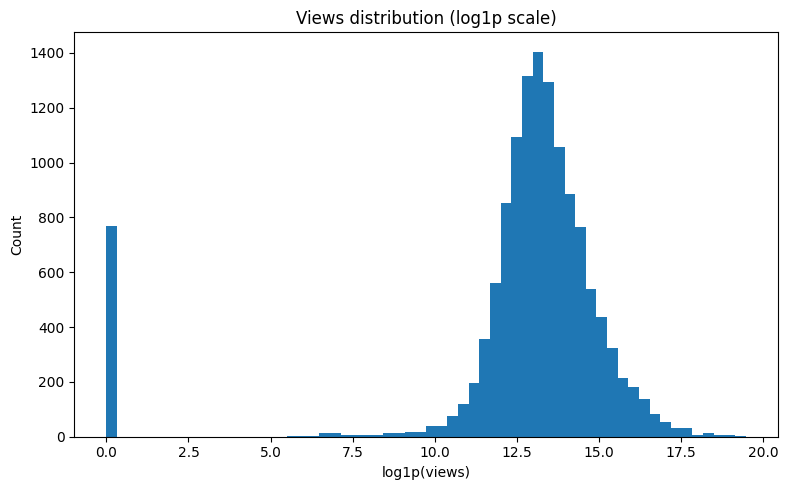


===== DURATION (LONG-FORM) SUMMARY (seconds) =====
              value
count       12053.0
median_sec    649.0
p25_sec       194.0
p75_sec      1404.0
p90_sec      2314.8


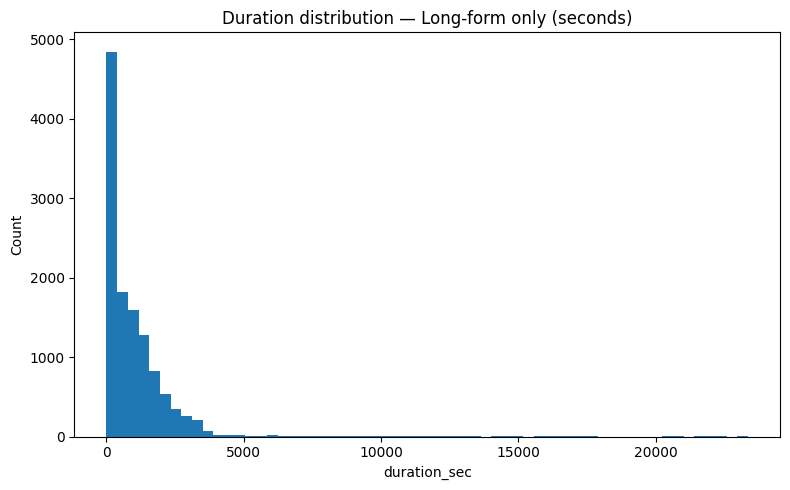


===== DAILY VOLUME (2025 onward, first/last 5 rows) =====
    publish_date  count  count_7d_ma
195   2025-01-01     19    12.714286
196   2025-01-02      9    13.142857
197   2025-01-03     19    14.000000
198   2025-01-04     20    16.142857
199   2025-01-05     23    17.285714
447   2025-09-11     37    35.714286
448   2025-09-12     49    36.714286
449   2025-09-13     29    36.285714
450   2025-09-14     29    35.857143
451   2025-09-15     15    33.857143


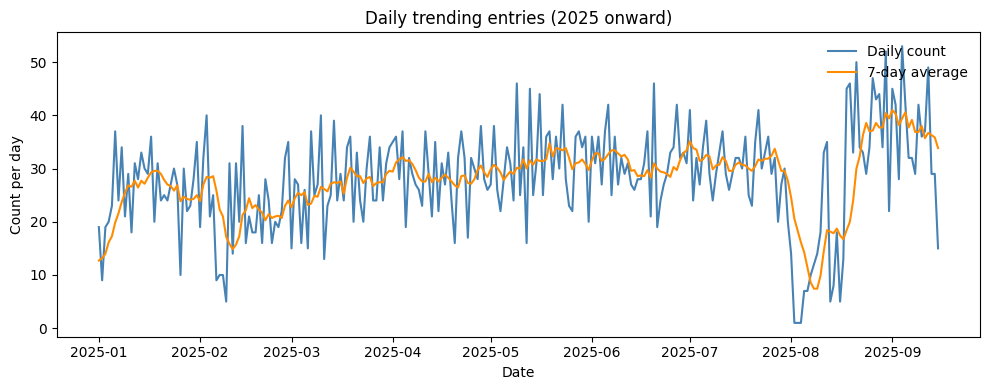


===== COMPOSITION =====
           metric  count  share_pct
0   verified_true   9281      71.30
1  verified_false   3736      28.70
2     shorts_true    590       4.53
3    shorts_false  12427      95.47


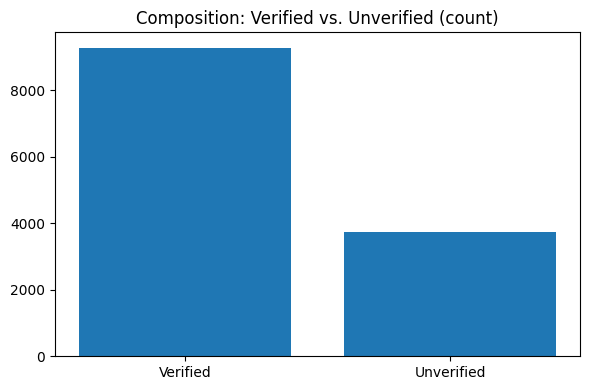

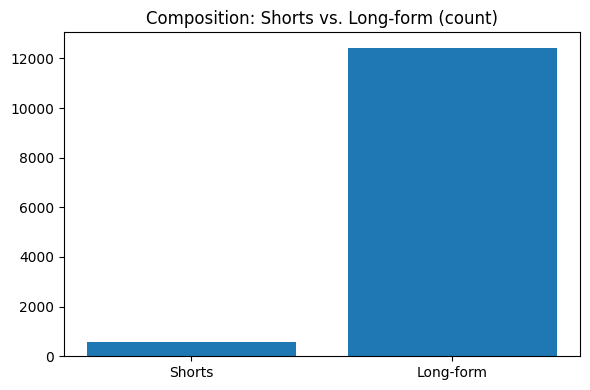

C:\Users\akato\AppData\Local\Temp\ipykernel_17212\2325734508.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["publish_dow","publish_hour"])


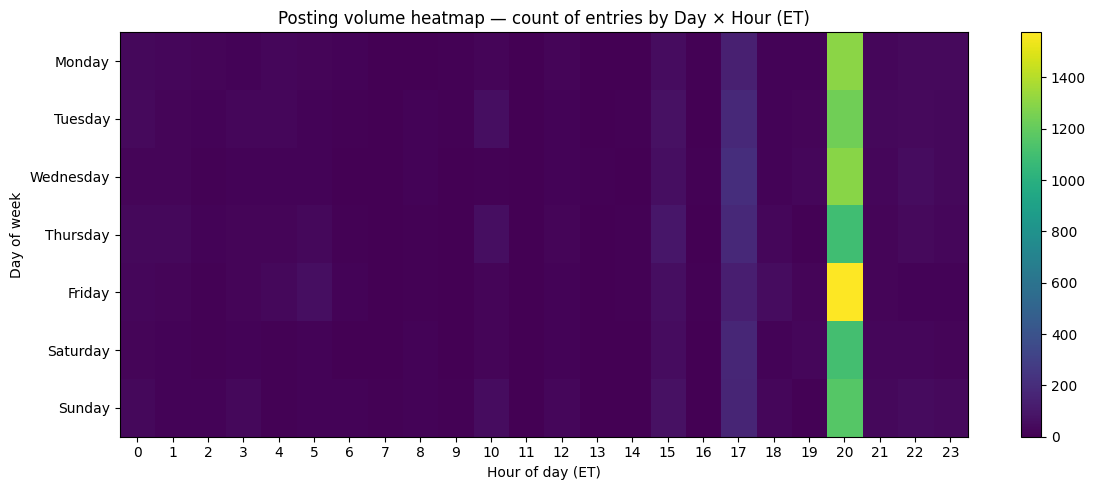


===== TOP 20 SPACE/SCIENCE CHANNELS BY COUNT =====
                 channelName  count
0            Westen Champlin     12
1       CarynandConnieGaming      7
2                 SolarBalls      5
3             HelloGamesTube      5
4           Evan and Katelyn      5
5                   StarTalk      5
6                Alec Steele      5
7                       NASA      4
8                        WWE      4
9   Universal Orlando Resort      3
10           NASASpaceflight      3
11           Spaceflight Now      3
12            arcsystemworks      3
13             Marvel Rivals      3
14               FX Networks      3
15                Kim Loaiza      3
16                    GLITCH      3
17            STEEZO THE GOD      3
18            VideoFromSpace      3
19                Mark Rober      2


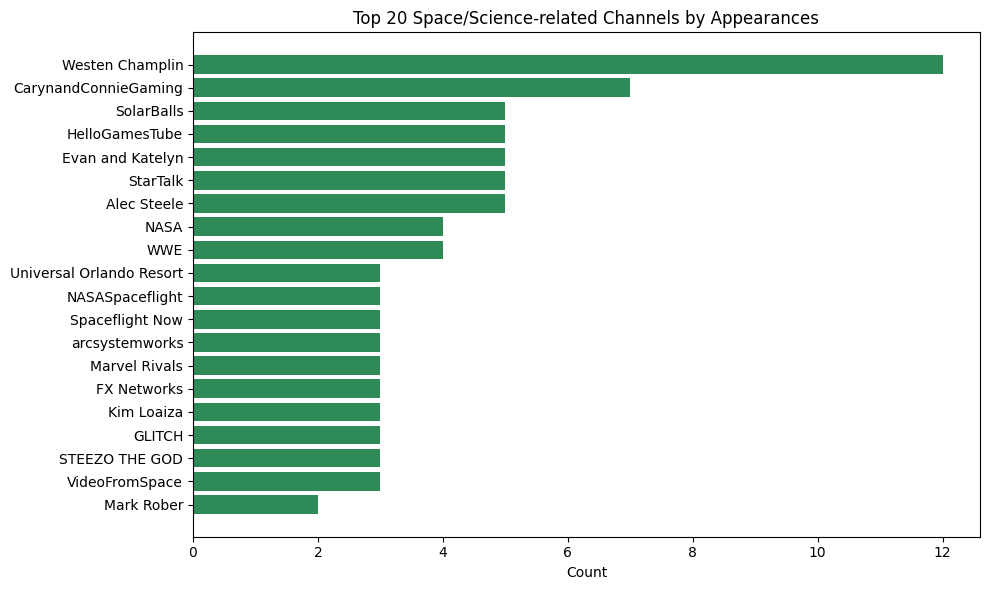


[INFO] Step 1.7 visuals saved to ./out_step1_7/


In [ ]:
# STEP 1.7 — Basic Visualizations (Foundational EDA)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- 0) Load cleaned data ----------
CLEAN_PATH = "Data./youtube_clean.csv"  # adjust if needed
df = pd.read_csv(CLEAN_PATH, low_memory=False, parse_dates=["published_at"])

os.makedirs("./out_step1_7", exist_ok=True)

print("[INFO] Loaded cleaned dataset")
print(f"Rows: {len(df):,} | Columns: {len(df.columns)}")
print("\n===== Columns =====")
print(", ".join(df.columns))

# Ensure ET fields exist (if not created earlier)
if "published_at_et" not in df.columns:
    if df["published_at"].dt.tz is None:
        df["published_at"] = df["published_at"].dt.tz_localize("UTC")
    df["published_at_et"] = df["published_at"].dt.tz_convert("America/New_York")
if "publish_date" not in df.columns:
    df["publish_date"] = df["published_at_et"].dt.date
if "publish_hour" not in df.columns:
    df["publish_hour"] = df["published_at_et"].dt.hour
if "publish_dow" not in df.columns:
    df["publish_dow"] = df["published_at_et"].dt.day_name()

dow_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
df["publish_dow"] = pd.Categorical(df["publish_dow"], categories=dow_order, ordered=True)

# ---------- 1) Views distribution (log scale) ----------
views = df["views"].astype(float)
q = views.quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).to_frame("views").reset_index().rename(columns={"index":"quantile"})

print("\n===== VIEWS QUANTILES =====")
print(q)

plt.figure(figsize=(8,5))
plt.hist(np.log1p(views), bins=60)
plt.title("Views distribution (log1p scale)")
plt.xlabel("log1p(views)")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("./out_step1_7/fig_views_hist_log.png", dpi=150)
plt.show()

# ---------- 2) Duration distribution (long-form only) ----------
dur = df.loc[(df.get("isShort", False) == False), "duration_sec"].astype("float")
dur = dur.dropna()
dur = dur[dur <= dur.quantile(0.995)]  # clip extreme tail for readability

dur_stats = pd.Series({
    "count": dur.shape[0],
    "median_sec": np.median(dur),
    "p25_sec": np.percentile(dur, 25),
    "p75_sec": np.percentile(dur, 75),
    "p90_sec": np.percentile(dur, 90),
}).round(2)

print("\n===== DURATION (LONG-FORM) SUMMARY (seconds) =====")
print(dur_stats.to_frame("value"))

plt.figure(figsize=(8,5))
plt.hist(dur, bins=60)
plt.title("Duration distribution — Long-form only (seconds)")
plt.xlabel("duration_sec")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("./out_step1_7/fig_duration_hist_longform.png", dpi=150)
plt.show()

# ---------- 3) Upload volume over time (daily counts, 2025 onward) ----------
daily = df.groupby("publish_date").size().rename("count").to_frame().reset_index()
daily["publish_date"] = pd.to_datetime(daily["publish_date"])
daily = daily.sort_values("publish_date")
daily["count_7d_ma"] = daily["count"].rolling(7, min_periods=1).mean()

# restrict to Jan 2025 → most recent
daily_recent = daily[daily["publish_date"] >= "2025-01-01"]

print("\n===== DAILY VOLUME (2025 onward, first/last 5 rows) =====")
print(pd.concat([daily_recent.head(), daily_recent.tail()], axis=0))

plt.figure(figsize=(10,4))
plt.plot(daily_recent["publish_date"], daily_recent["count"], label="Daily count", color="steelblue")
plt.plot(daily_recent["publish_date"], daily_recent["count_7d_ma"], label="7-day average", color="darkorange")
plt.title("Daily trending entries (2025 onward)")
plt.xlabel("Date")
plt.ylabel("Count per day")
plt.legend(loc="upper right", frameon=False)
plt.tight_layout()
plt.savefig("./out_step1_7/fig_daily_volume.png", dpi=150)
plt.show()


# ---------- 4) Composition bars (verified / shorts) ----------
comp = pd.DataFrame({
    "verified_true": [df.get("verified", pd.Series(False)).sum()],
    "verified_false": [(~df.get("verified", pd.Series(False))).sum()],
    "shorts_true": [df.get("isShort", pd.Series(False)).sum()],
    "shorts_false": [(~df.get("isShort", pd.Series(False))).sum()],
})
total = len(df)

print("\n===== COMPOSITION =====")
print(pd.DataFrame({
    "metric": ["verified_true","verified_false","shorts_true","shorts_false"],
    "count": [int(comp["verified_true"][0]), int(comp["verified_false"][0]),
              int(comp["shorts_true"][0]), int(comp["shorts_false"][0])],
    "share_pct": [100*comp["verified_true"][0]/total, 100*comp["verified_false"][0]/total,
                  100*comp["shorts_true"][0]/total, 100*comp["shorts_false"][0]/total]
}).round(2))

# Verified bar
plt.figure(figsize=(6,4))
plt.bar(["Verified","Unverified"], [int(comp["verified_true"][0]), int(comp["verified_false"][0])])
plt.title("Composition: Verified vs. Unverified (count)")
plt.tight_layout()
plt.savefig("./out_step1_7/fig_bar_verified.png", dpi=150)
plt.show()

# Shorts bar
plt.figure(figsize=(6,4))
plt.bar(["Shorts","Long-form"], [int(comp["shorts_true"][0]), int(comp["shorts_false"][0])])
plt.title("Composition: Shorts vs. Long-form (count)")
plt.tight_layout()
plt.savefig("./out_step1_7/fig_bar_shorts.png", dpi=150)
plt.show()

# ---------- 5) Posting volume heatmap by Day × Hour (ET) ----------
vol_pivot = (
    df.groupby(["publish_dow","publish_hour"])
      .size().rename("n").reset_index()
      .pivot(index="publish_dow", columns="publish_hour", values="n")
      .reindex(index=dow_order)
)

plt.figure(figsize=(12,5))
plt.imshow(vol_pivot.values, aspect="auto", origin="upper")
plt.title("Posting volume heatmap — count of entries by Day × Hour (ET)")
plt.xlabel("Hour of day (ET)")
plt.ylabel("Day of week")
plt.xticks(range(24), range(24))
plt.yticks(range(len(dow_order)), dow_order)
plt.colorbar()
plt.tight_layout()
plt.savefig("./out_step1_7/fig_heatmap_volume.png", dpi=150)
plt.show()

keywords = ["space","nasa","astronomy","cosmos","planet","astrophysics"]

mask = df["title"].fillna("").str.lower().str.contains("|".join(keywords)) | \
       df["description"].fillna("").str.lower().str.contains("|".join(keywords))

df_space = df[mask]

top_n = 20
if "channelName" in df_space.columns and not df_space.empty:
    top_channels_space = (
        df_space["channelName"].value_counts().head(top_n)
        .to_frame("count").reset_index().rename(columns={"index":"channelName"})
    )
    print(f"\n===== TOP {top_n} SPACE/SCIENCE CHANNELS BY COUNT =====")
    print(top_channels_space)

    plt.figure(figsize=(10,6))
    plt.barh(top_channels_space["channelName"][::-1], top_channels_space["count"][::-1], color="seagreen")
    plt.title(f"Top {top_n} Space/Science-related Channels by Appearances")
    plt.xlabel("Count")
    plt.tight_layout()
    plt.savefig("./out_step1_7/fig_barh_top_channels_space.png", dpi=150)
    plt.show()
else:
    print("\n[INFO] No space/science-related channels found with given keywords.")

# ---------- 6) Top channels by appearances ----------
#top_n = 20
#if "channelName" in df.columns:
    #top_channels = df["channelName"].value_counts().head(top_n).to_frame("count").reset_index().rename(columns={"index":"channelName"})
    #print(f"\n===== TOP {top_n} CHANNELS BY COUNT =====")
    #plt.barh(top_channels["channelName"][::-1], top_channels["count"][::-1])
    #plt.title(f"Top {top_n} channels by appearances in dataset")
    #plt.xlabel("Count")
    #plt.tight_layout()
    #plt.savefig("./out_step1_7/fig_barh_top_channels.png", dpi=150)
    #plt.show()

print("\n[INFO] Step 1.7 visuals saved to ./out_step1_7/")


# Step 2 Temporal Analysis
### in this step, we are reading the youtube_clean.csv from Step 1.6, converts timestamps to America/New_York, builds hour/day features, and outputs clean tables + heatmaps and ranked recommendations.

### This solves the problem: When should we post our content based on our format?

## Step 2.1 Load cleaned data & prepare time features (ET)

In [16]:
# STEP 2.1 — Load cleaned data & build ET time features

import pandas as pd
import numpy as np
from datetime import timezone

# Read the cleaned dataset from Step 1.6
CLEAN_PATH = "./Data/youtube_clean.csv"
df = pd.read_csv(CLEAN_PATH, low_memory=False, parse_dates=["published_at"])

# Ensure timezone-aware → convert to ET for human planning
# If published_at already tz-aware, tz_convert; else localize to UTC first.
if df["published_at"].dt.tz is None:
    df["published_at"] = df["published_at"].dt.tz_localize("UTC")

df["published_at_et"] = df["published_at"].dt.tz_convert("America/New_York")

# Extract day-of-week and hour (ET)
df["dow_et"] = df["published_at_et"].dt.day_name()
df["hour_et"] = df["published_at_et"].dt.hour

# For consistent ordering in pivot tables
dow_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
df["dow_et"] = pd.Categorical(df["dow_et"], categories=dow_order, ordered=True)

# Basic guardrails
n_missing_time = df["published_at_et"].isna().sum()
print(f"[INFO] Time rows missing (after tz handling): {n_missing_time}")
print(f"[INFO] Rows available for temporal analysis: {len(df) - n_missing_time:,}")


[INFO] Time rows missing (after tz handling): 0
[INFO] Rows available for temporal analysis: 13,017


### Step 2.2 Define metrics & splits

We’ll use median of log1p(views) as the robust metric (handles heavy tail).
We’ll also compute 75th percentile of log1p(views) as a “high-perf” view.

We use median log1p(views) because taking the log shrinks very large numbers so they don’t overpower the data, and the median shows the “typical” video instead of being skewed by outliers. The 75th percentile log1p(views) tells us what strong performers (the top 25%) look like, so together these metrics show both the normal case and the “good outcome” case without being tricked by a few viral hits.


In [17]:
# STEP 2.2 — Define robust metrics & analysis splits

def agg_views_metrics(x: pd.Series) -> pd.Series:
    x = np.log1p(x)  # robust scale
    return pd.Series({
        "n": x.size,
        "median_logv": float(np.nanmedian(x)) if x.size else np.nan,
        "p75_logv": float(np.nanpercentile(x, 75)) if x.size else np.nan
    })

def build_pivot(frame: pd.DataFrame, value_col="views"):
    # group by (day, hour) in ET
    g = frame.groupby(["dow_et","hour_et"], dropna=True)[value_col].apply(agg_views_metrics)
    # g is a MultiIndex → pivot to two tables for the two metrics
    tbl = g.unstack(level=-1)  # columns are metrics
    # We want separate wide tables per metric for heatmaps:
    med = tbl["median_logv"].unstack("hour_et")
    p75 = tbl["p75_logv"].unstack("hour_et")
    n   = tbl["n"].unstack("hour_et")
    return med, p75, n

# Splits to analyze
splits = {
    "ALL": df,
    "SHORTS": df[df["isShort"] == True],
    "LONGFORM": df[df["isShort"] == False],
    "VERIFIED": df[df["verified"] == True],
    "UNVERIFIED": df[df["verified"] == False],
}

# Optional combined splits (format x authority)
splits["SHORTS_VERIFIED"] = df[(df["isShort"] == True) & (df["verified"] == True)]
splits["SHORTS_UNVERIFIED"] = df[(df["isShort"] == True) & (df["verified"] == False)]
splits["LONG_VERIFIED"] = df[(df["isShort"] == False) & (df["verified"] == True)]
splits["LONG_UNVERIFIED"] = df[(df["isShort"] == False) & (df["verified"] == False)]

# Quick size report
for k, sub in splits.items():
    print(f"[INFO] {k:>16}: {len(sub):,} rows")


[INFO]              ALL: 13,017 rows
[INFO]           SHORTS: 590 rows
[INFO]         LONGFORM: 12,427 rows
[INFO]         VERIFIED: 9,281 rows
[INFO]       UNVERIFIED: 3,736 rows
[INFO]  SHORTS_VERIFIED: 9 rows
[INFO] SHORTS_UNVERIFIED: 581 rows
[INFO]    LONG_VERIFIED: 9,272 rows
[INFO]  LONG_UNVERIFIED: 3,155 rows


### Step 2.3 Build heatmap tables & save CSVs

In [15]:
# STEP 2.3 — Generate pivot tables & save summaries

import os
OUT_DIR = "./out_step2_temporal"
os.makedirs(OUT_DIR, exist_ok=True)

pivot_results = {}  # store (median, p75, n) per split

for name, sub in splits.items():
    if sub.empty:
        print(f"[WARN] Split '{name}' is empty, skipping.")
        continue
    med, p75, n = build_pivot(sub, value_col="views")
    pivot_results[name] = {"median_logv": med, "p75_logv": p75, "n": n}

    # Save CSVs for inspection/reporting
    med.to_csv(os.path.join(OUT_DIR, f"{name}_median_logviews.csv"))
    p75.to_csv(os.path.join(OUT_DIR, f"{name}_p75_logviews.csv"))
    n.to_csv(os.path.join(OUT_DIR, f"{name}_counts.csv"))

print(f"[INFO] Saved pivot CSVs to: {OUT_DIR}")


C:\Users\akato\AppData\Local\Temp\ipykernel_9712\2649613564.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = frame.groupby(["dow_et","hour_et"], dropna=True)[value_col].apply(agg_views_metrics)
C:\Users\akato\AppData\Local\Temp\ipykernel_9712\2649613564.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = frame.groupby(["dow_et","hour_et"], dropna=True)[value_col].apply(agg_views_metrics)
C:\Users\akato\AppData\Local\Temp\ipykernel_9712\2649613564.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to reta

[INFO] Saved pivot CSVs to: ./out_step2_temporal


C:\Users\akato\AppData\Local\Temp\ipykernel_9712\2649613564.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = frame.groupby(["dow_et","hour_et"], dropna=True)[value_col].apply(agg_views_metrics)


### Step 2.4 Visualize heatmaps

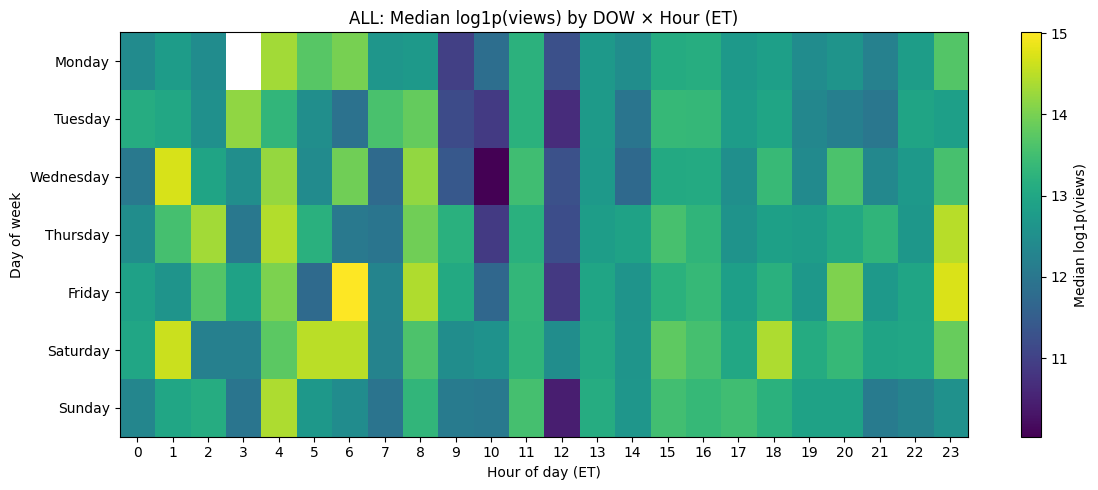

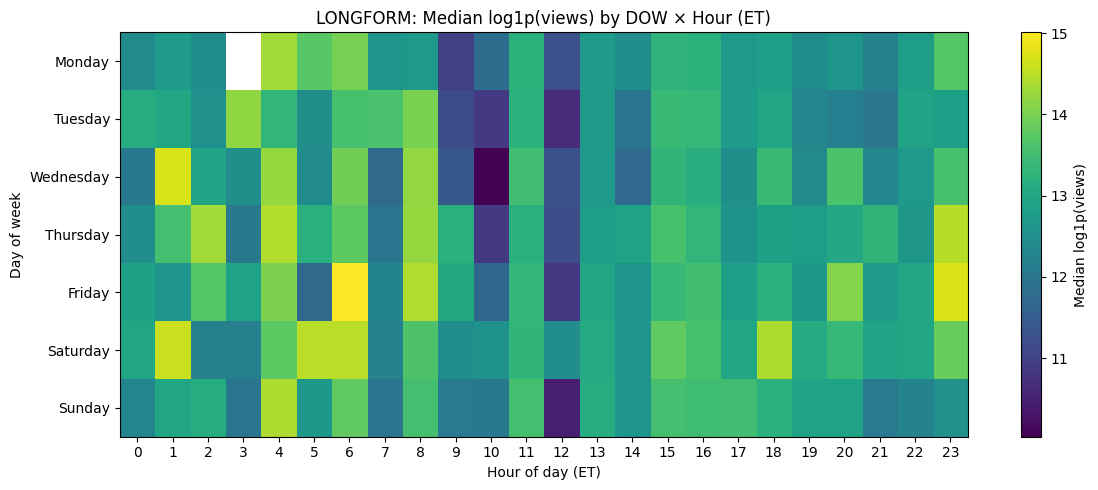

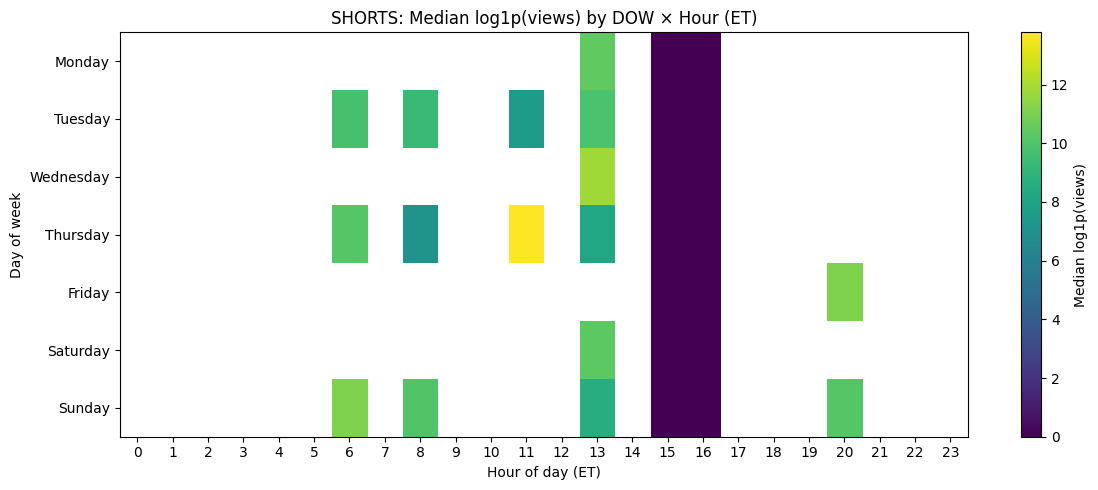

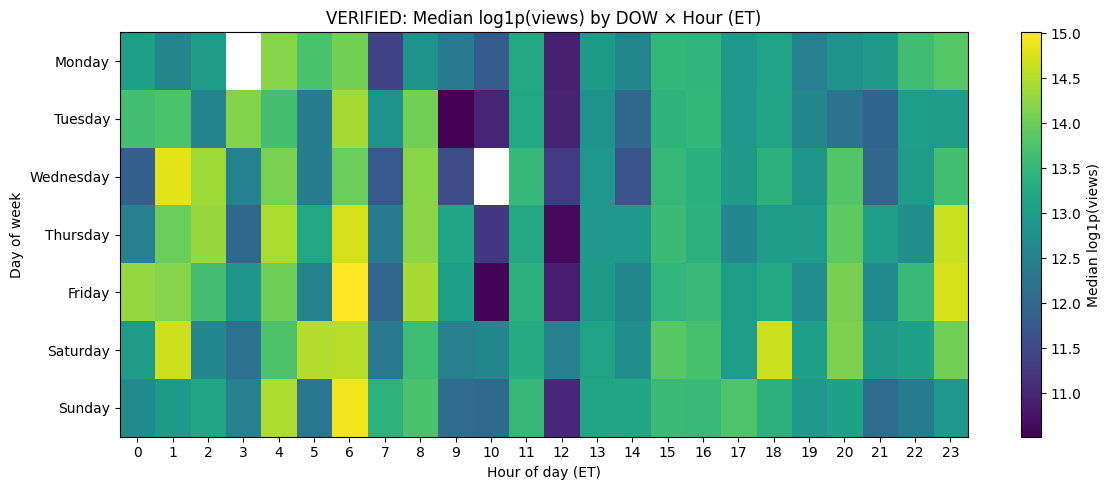

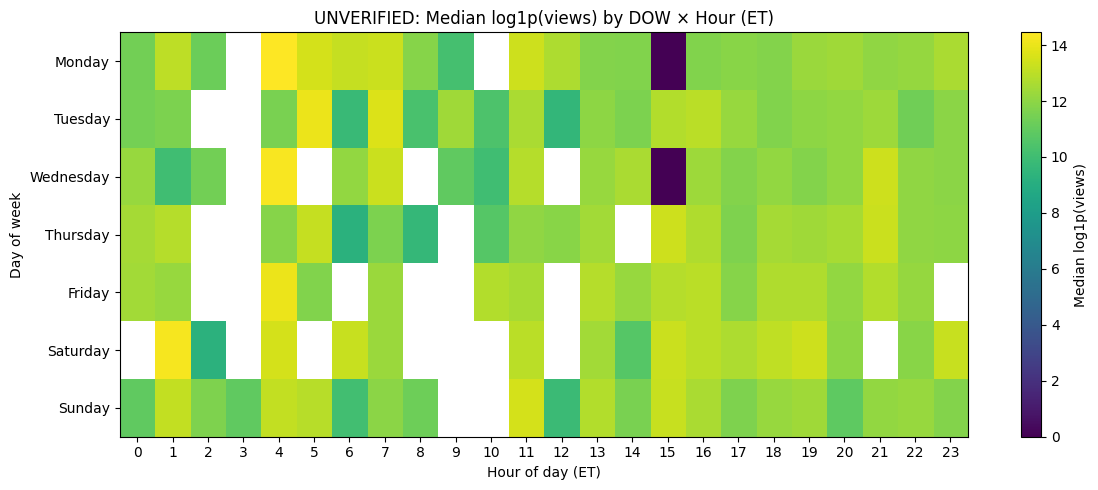

In [18]:
# STEP 2.4 — Heatmap plots for key splits (matplotlib only)

import matplotlib.pyplot as plt
import numpy as np

def plot_heatmap(table: pd.DataFrame, title: str):
    # Ensure hour columns exist 0..23, fill if missing
    hrs = list(range(24))
    table = table.reindex(columns=hrs)
    # If table empty, skip
    if table.empty:
        print(f"[WARN] Empty table for {title}, skipping heatmap.")
        return
    data = table.values

    fig, ax = plt.subplots(figsize=(12, 5))
    im = ax.imshow(data, aspect="auto", origin="upper")
    ax.set_title(title)
    ax.set_xlabel("Hour of day (ET)")
    ax.set_ylabel("Day of week")
    ax.set_xticks(range(24))
    ax.set_xticklabels(range(24))
    ax.set_yticks(range(len(table.index)))
    ax.set_yticklabels(list(table.index))
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("Median log1p(views)")
    plt.tight_layout()
    plt.show()

# Choose a few core splits to visualize
for key in ["ALL","LONGFORM","SHORTS","VERIFIED","UNVERIFIED"]:
    if key in pivot_results:
        plot_heatmap(pivot_results[key]["median_logv"], f"{key}: Median log1p(views) by DOW × Hour (ET)")


### Step 2.5 — Rank top posting windows per split (with min n filter)

n is the number of videos in that specific day–hour bucket after cleaning and within that split.

if the min_n sample size filter out the super sparse cells so we don’t recommend times based on too few examples.

In [19]:
# STEP 2.5 — Rank top posting windows per split (with min n filter)

def rank_windows(pivots_dict, split_name, min_n=20, top_k=15):
    res = pivots_dict.get(split_name)
    if not res:
        return None
    med = res["median_logv"]
    n = res["n"]

    # Align and filter by min_n
    common = med.copy()
    n_aligned = n.reindex_like(med)
    mask = n_aligned >= min_n
    common = common.where(mask)

    # Stack to rows and sort
    ranked = (
        common.stack()
        .reset_index()
        .rename(columns={"dow_et": "day", "hour_et": "hour", 0: "median_logv"})
        .dropna(subset=["median_logv"])
        .sort_values("median_logv", ascending=False)
        .head(top_k)
    )
    # add counts for transparency
    counts_for_ranked = (
        n_aligned.stack()
        .reset_index()
        .rename(columns={0: "n", "dow_et": "day", "hour_et": "hour"})
    )
    ranked = ranked.merge(counts_for_ranked, on=["day", "hour"], how="left")

    # Convert back from log-space for interpretability (approx median views)
    ranked["approx_median_views"] = (np.exp(ranked["median_logv"]) - 1).round().astype("Int64")

    # Reorder columns
    ranked = ranked[["day","hour","n","median_logv","approx_median_views"]]
    return ranked

ranked_tables = {}
for key in ["ALL","LONGFORM","SHORTS","VERIFIED","UNVERIFIED","LONG_VERIFIED","LONG_UNVERIFIED","SHORTS_VERIFIED","SHORTS_UNVERIFIED"]:
    if key in pivot_results:
        ranked = rank_windows(pivot_results, key, min_n=20, top_k=15)
        if ranked is not None and not ranked.empty:
            ranked_tables[key] = ranked
            print(f"\n===== TOP WINDOWS — {key} =====")
            display(ranked)
            # Save
            ranked.to_csv(os.path.join(OUT_DIR, f"{key}_top_windows.csv"), index=False)
        else:
            print(f"\n[WARN] No ranked windows for {key} (maybe too sparse after min_n filter).")


===== TOP WINDOWS — ALL =====


,day,hour,n,median_logv,approx_median_views
0,Friday,6,20.0,15.009785,3301161
1,Saturday,6,20.0,14.492075,1967107
2,Saturday,18,29.0,14.396343,1787524
3,Friday,20,23.0,14.041589,1253673
4,Thursday,8,22.0,13.924690,1115362
5,Saturday,23,29.0,13.861765,1047340
6,Saturday,15,385.0,13.776303,961550
7,Monday,23,25.0,13.674218,868234
8,Wednesday,20,32.0,13.593612,800996
9,Wednesday,23,25.0,13.555182,770797



===== TOP WINDOWS — LONGFORM =====


,day,hour,n,median_logv,approx_median_views
0,Friday,6,20.0,15.009785,3301161
1,Saturday,6,20.0,14.492075,1967107
2,Saturday,18,29.0,14.396343,1787524
3,Friday,20,21.0,14.079931,1302675
4,Saturday,23,29.0,13.861765,1047340
5,Saturday,15,376.0,13.799110,983732
6,Sunday,6,33.0,13.793460,978190
7,Thursday,6,36.0,13.758286,944381
8,Monday,23,25.0,13.674218,868234
9,Wednesday,20,32.0,13.593612,800996



===== TOP WINDOWS — SHORTS =====


,day,hour,n,median_logv,approx_median_views
0,Sunday,6,20.0,11.136241,68612
1,Thursday,6,23.0,10.144196,25442
2,Tuesday,6,21.0,9.757479,17282
3,Monday,15,63.0,0.000000,0
4,Monday,16,52.0,0.000000,0
5,Wednesday,15,71.0,0.000000,0
6,Wednesday,16,51.0,0.000000,0
7,Friday,15,61.0,0.000000,0
8,Friday,16,88.0,0.000000,0
9,Sunday,16,26.0,0.000000,0



===== TOP WINDOWS — VERIFIED =====


,day,hour,n,median_logv,approx_median_views
0,Friday,6,20.0,15.009785,3301161
1,Sunday,6,20.0,14.910976,2990572
2,Thursday,6,23.0,14.721917,2475410
3,Saturday,18,25.0,14.656892,2319567
4,Tuesday,6,26.0,14.396536,1787870
5,Saturday,20,28.0,14.127074,1365558
6,Saturday,23,22.0,14.045670,1258800
7,Thursday,1,20.0,13.998508,1200810
8,Saturday,15,309.0,13.850438,1035544
9,Monday,23,21.0,13.825967,1010510



===== TOP WINDOWS — UNVERIFIED =====


,day,hour,n,median_logv,approx_median_views
0,Thursday,15,88.0,13.333948,617816
1,Saturday,15,76.0,13.279903,585313
2,Sunday,15,82.0,13.218528,550469
3,Saturday,16,175.0,12.984204,435479
4,Friday,16,524.0,12.982687,434819
5,Tuesday,16,238.0,12.959460,424836
6,Friday,13,21.0,12.870110,388523
7,Friday,15,274.0,12.818968,369153
8,Tuesday,15,103.0,12.799792,362141
9,Thursday,16,223.0,12.750380,344682



===== TOP WINDOWS — LONG_VERIFIED =====


,day,hour,n,median_logv,approx_median_views
0,Friday,6,20.0,15.009785,3301161
1,Sunday,6,20.0,14.910976,2990572
2,Thursday,6,23.0,14.721917,2475410
3,Saturday,18,25.0,14.656892,2319567
4,Tuesday,6,26.0,14.396536,1787870
5,Saturday,20,28.0,14.127074,1365558
6,Saturday,23,22.0,14.045670,1258800
7,Thursday,1,20.0,13.998508,1200810
8,Saturday,15,309.0,13.850438,1035544
9,Monday,23,21.0,13.825967,1010510



===== TOP WINDOWS — LONG_UNVERIFIED =====


,day,hour,n,median_logv,approx_median_views
0,Thursday,15,81.0,13.486215,719429
1,Saturday,15,67.0,13.473623,710427
2,Friday,16,436.0,13.443706,689488
3,Sunday,15,72.0,13.363516,636357
4,Friday,15,220.0,13.119211,498426
5,Saturday,16,160.0,13.088399,483302
6,Tuesday,16,229.0,13.017989,450443
7,Tuesday,15,94.0,12.953638,422370
8,Friday,13,21.0,12.870110,388523
9,Thursday,16,213.0,12.845932,379242



[WARN] No ranked windows for SHORTS_VERIFIED (maybe too sparse after min_n filter).

===== TOP WINDOWS — SHORTS_UNVERIFIED =====


,day,hour,n,median_logv,approx_median_views
0,Sunday,6,20.0,11.136241,68612
1,Thursday,6,23.0,10.144196,25442
2,Tuesday,6,21.0,9.757479,17282
3,Monday,15,63.0,0.000000,0
4,Monday,16,52.0,0.000000,0
5,Wednesday,15,71.0,0.000000,0
6,Wednesday,16,49.0,0.000000,0
7,Friday,15,54.0,0.000000,0
8,Friday,16,88.0,0.000000,0
9,Sunday,16,26.0,0.000000,0


### Step 2.7 — Posting calendar heatmaps (Unverified Long-form & Shorts)

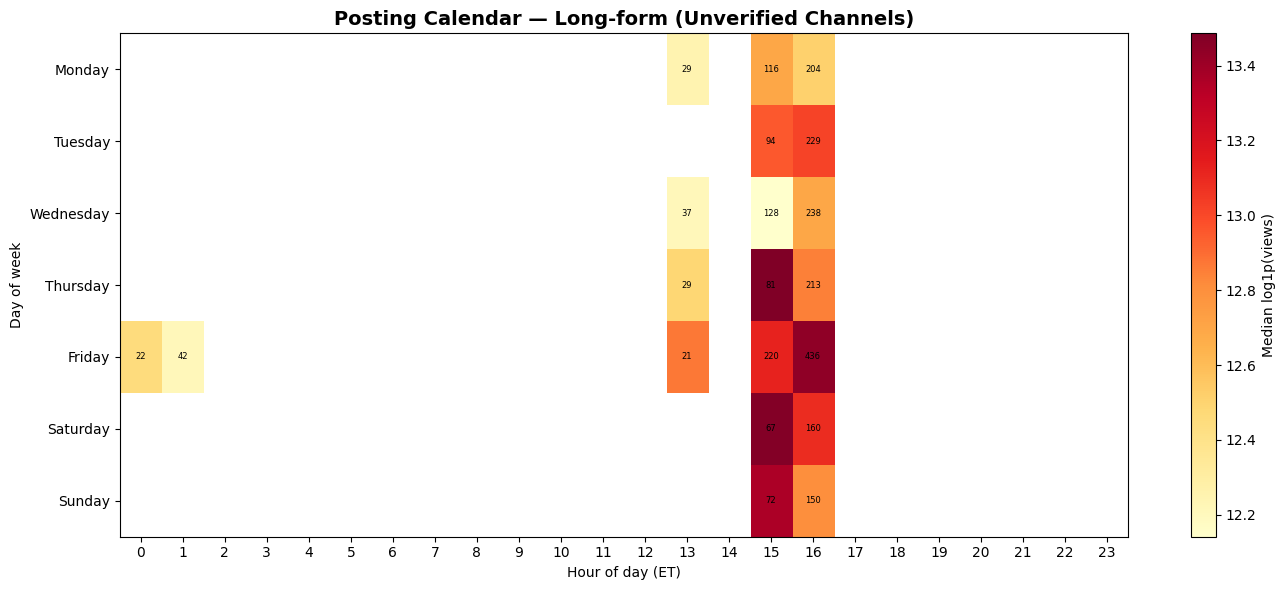

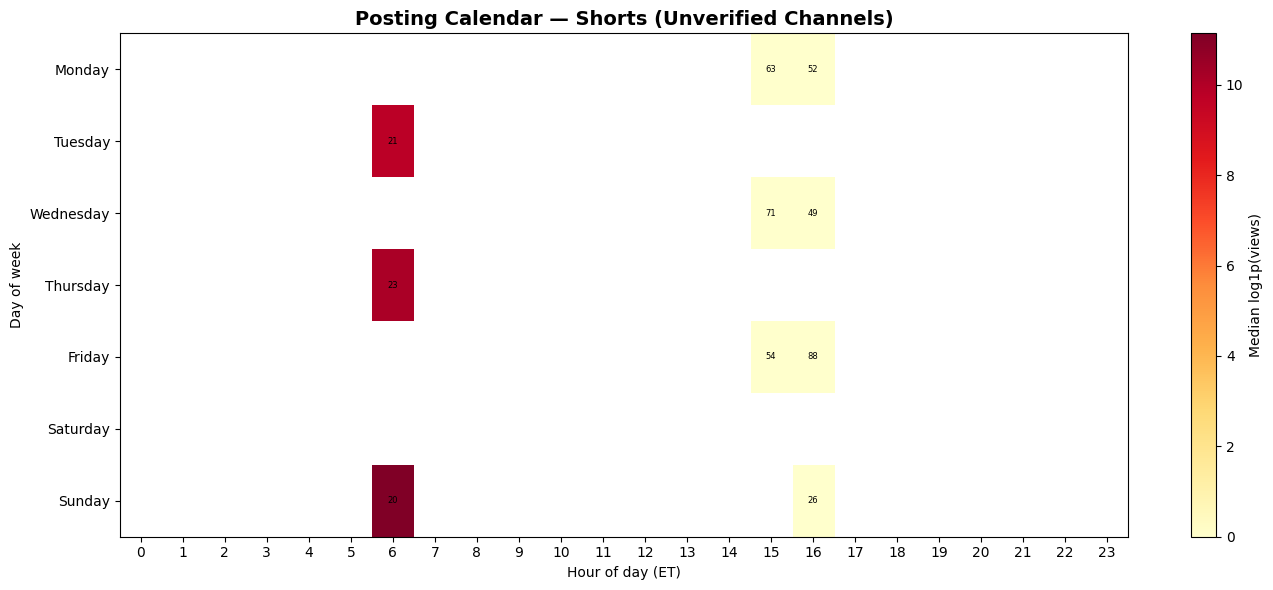

In [20]:
# STEP 2.7 — Posting calendar heatmaps (Unverified Long-form & Shorts)

import matplotlib.pyplot as plt
import numpy as np

def plot_posting_calendar(median_table, count_table, title, cmap="YlOrRd", min_n=20):
    """
    Heatmap of recommended posting times.
    Rows = days, cols = hours (ET).
    Colors = median log1p(views).
    Cells with <min_n samples are blanked.
    """
    # Ensure 0..23 hours present
    hrs = list(range(24))
    table = median_table.reindex(columns=hrs)
    counts = count_table.reindex(columns=hrs)

    # Mask low-sample cells
    mask = counts < min_n
    data = table.where(~mask)

    fig, ax = plt.subplots(figsize=(14, 6))
    im = ax.imshow(data, aspect="auto", origin="upper", cmap=cmap)

    # Labeling
    ax.set_title(title, fontsize=14, weight="bold")
    ax.set_xlabel("Hour of day (ET)")
    ax.set_ylabel("Day of week")
    ax.set_xticks(range(24))
    ax.set_xticklabels(range(24))
    ax.set_yticks(range(len(data.index)))
    ax.set_yticklabels(list(data.index))

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("Median log1p(views)")

    # Overlay sample sizes for transparency
    for i, day in enumerate(data.index):
        for j, hr in enumerate(data.columns):
            n = counts.loc[day, hr]
            if not np.isnan(data.loc[day, hr]) and n >= min_n:
                ax.text(j, i, str(int(n)), ha="center", va="center", color="black", fontsize=6)

    plt.tight_layout()
    plt.show()

# Plot for Unverified Long-form
if "LONG_UNVERIFIED" in pivot_results:
    plot_posting_calendar(
        pivot_results["LONG_UNVERIFIED"]["median_logv"],
        pivot_results["LONG_UNVERIFIED"]["n"],
        "Posting Calendar — Long-form (Unverified Channels)"
    )

# Plot for Unverified Shorts
if "SHORTS_UNVERIFIED" in pivot_results:
    plot_posting_calendar(
        pivot_results["SHORTS_UNVERIFIED"]["median_logv"],
        pivot_results["SHORTS_UNVERIFIED"]["n"],
        "Posting Calendar — Shorts (Unverified Channels)"
    )


### Step 2 Observations — Posting Times
1. Overall (ALL videos)

Friday 6 AM ET and Saturday 6 AM ET stand out with the highest median views (~2–3.3M), but note that n=20 → very few samples. These could be special events (e.g., premieres) rather than general rules.

Saturday afternoon (15–16h ET) and Thursday 15h ET also rank high, but with hundreds of samples — much more reliable.

Interpretation: Early-morning spikes may reflect global releases, but for a repeatable strategy the Saturday/Sunday afternoon (15–16h ET) and Thursday afternoon (15h ET) windows are safer bets.

2. Long-form

Friday & Saturday 6 AM ET again top the list, but small samples.

Saturday 15–16h ET and Thursday 15h ET are very strong with large n (hundreds).

Sunday morning (6–8h ET) also shows up — weekend morning content may get attention from relaxed audiences.

Interpretation: For long videos, weekend afternoons (Sat/Sun 3–4 PM ET) and Thursday afternoons (3 PM ET) are robust high-yield windows.

3. Shorts

Sunday 6 AM ET is the top performer (~68K median views) but based on only 20 videos.

Other weekday 6 AM slots (Tue, Thu) show moderate medians (~17–25K).

Large afternoon buckets (Mon–Fri 15–16h ET) show 0 median → Shorts are unpredictable in this dataset. Many Shorts get very low traction even in busy hours.

Interpretation: Shorts may benefit from early morning uploads (6 AM ET), possibly catching global audiences. Afternoon slots are oversaturated and median performance drops to near-zero.

4. Verified vs. Unverified

Verified creators: Top windows (Fri/Sat/Sun 6 AM ET, Thu 6 AM ET, Sat 18–20h ET) achieve ~1–3M median views even with small n. Verified also do well in Saturday afternoon (15–16h ET) with large n (hundreds).

Unverified creators: Strongest windows are Thu/Sat/Sun 15h ET and Fri 16h ET, with ~0.4–0.7M median views. Notice the medians are much lower than verified peers.

Interpretation: Verified creators can succeed in many slots (morning & evening), but unverified channels see better outcomes in weekend + weekday afternoons (3–4 PM ET). Authority matters a lot.

5. Long-form Verified vs. Unverified

Verified Long-form: Top slots align with overall trends — Fri/Sat/Sun 6 AM ET and Thu 6 AM ET (millions of views). Afternoon slots still strong.

Unverified Long-form: Clearer picture — Thu/Sat/Sun 15h ET and Fri 15–16h ET dominate, with ~0.4–0.7M medians.

Interpretation: If you’re not verified, stick with afternoon uploads (esp. Thu/Sat/Sun 15–16h ET). Morning hours appear to benefit mostly established channels.

6. Shorts Verified vs. Unverified

Verified Shorts: Too sparse to rank (not enough data).

Unverified Shorts: Best window is Sunday 6 AM ET (~68K views); Tue/Thu 6 AM also positive but smaller. Afternoons collapse to near-zero.

Interpretation: For Shorts without authority, early morning uploads (6 AM ET) may be the only reliable window.

### Key Takeaways

#### Morning vs. Afternoon:

Verified channels can thrive in early morning (6 AM ET) slots — possibly global premieres.

Non-verified channels do best in afternoon (15–16h ET) slots — when local US audiences are active.

#### Weekends Matter:

Saturday & Sunday afternoons (15–16h ET) consistently strong across long-form and unverified splits.

Good balance of high views + large sample sizes (reliable).

#### Shorts are tricky:

Many Shorts get 0 traction.

Best chance for unverified Shorts: Sunday/Tue/Thu at 6 AM ET.

#### Authority gap:

Verified creators pull millions in multiple slots.

Unverified need to be laser-focused: Thurs/Fri/Sat/Sun afternoons.

#### Posting time strategy:
👉 suggestion for your channel strategy:

If long-form & unverified → prioritize Thu/Sat/Sun 15–16h ET.

If Shorts & unverified → experiment with 6 AM ET (esp. Sunday).

Track the results: if we see early engagement lift in these windows, double down; if not, iterate with weekday evening (Wed/Thu 20–23h ET) as backup.

## Step 3 Title & Description Analysis
in this step, we are reading the youtube_clean.csv from Step 1.6, and analyzing text features of video titles and descriptions — things like title length, use of punctuation, emojis, keywords, and sentiment.
this solves the problem: What kinds of words and styles in our titles & descriptions make videos more likely to perform well?

### Step 3.1 — Load Cleaned Dataset & Create Basic Length Features
in this step, we load the youtube_clean.csv (from Step 1.6) and create basic length features for titles and descriptions, including:

Title length (characters & words)

Description length (characters & words)

this solves the problem: How long are trending titles and descriptions, and is there a difference between short and long titles/descriptions?

In [21]:
# STEP 3.1 — Load cleaned dataset & create basic length features

import pandas as pd

# Load the cleaned dataset
CLEAN_PATH = "./Data/youtube_clean.csv"
df = pd.read_csv(CLEAN_PATH, low_memory=False, parse_dates=["published_at"])

# --- 1. Create title length features ---
df["title_len_chars"] = df["title"].astype(str).str.len()
df["title_len_words"] = df["title"].astype(str).str.split().str.len()

# --- 2. Create description length features ---
df["desc_len_chars"] = df["description"].astype(str).str.len()
df["desc_len_words"] = df["description"].astype(str).str.split().str.len()

# --- 3. Quick summary statistics ---
title_summary = df[["title_len_chars","title_len_words"]].describe().T
desc_summary  = df[["desc_len_chars","desc_len_words"]].describe().T

print("===== TITLE LENGTH SUMMARY =====")
display(title_summary)

print("\n===== DESCRIPTION LENGTH SUMMARY =====")
display(desc_summary)

# --- 4. Preview with new columns ---
cols_preview = ["title","title_len_chars","title_len_words","desc_len_chars","desc_len_words"]
print("\n===== SAMPLE ROWS (with length features) =====")
display(df[cols_preview].head(10))

# Save enriched dataset for next steps
STEP3_PATH = "./youtube_step3_titles.csv"
df.to_csv(STEP3_PATH, index=False)
print(f"\n[INFO] Saved dataset with Step 3.1 features to: {STEP3_PATH}")


===== TITLE LENGTH SUMMARY =====


,count,mean,std,min,25%,50%,75%,max
title_len_chars,13017.0,52.246601,21.559106,1.0,37.0,49.0,66.0,100.0
title_len_words,13017.0,9.030806,3.741767,1.0,6.0,9.0,11.0,26.0



===== DESCRIPTION LENGTH SUMMARY =====


,count,mean,std,min,25%,50%,75%,max
desc_len_chars,13017.0,169.643159,57.686810,1.0,187.0,192.0,196.0,200.0
desc_len_words,13017.0,23.820081,9.880208,1.0,19.0,27.0,31.0,53.0



===== SAMPLE ROWS (with length features) =====


,title,title_len_chars,title_len_words,desc_len_chars,desc_len_words
0,Concerning the Stranded Astronauts,34,4,198,32
1,FEEDING STARVING CELEBRITIES FT. MADELINE ARGY,46,6,42,8
2,Can You Beat my 200m Time 🔥,27,7,3,1
3,ASMR University,15,2,200,13
4,What if Earth grew 1cm every second?,36,7,189,29
5,Why Are Texas Interchanges So Tall?,35,6,187,22
6,A Wild Severe Weather Pattern Is Unfolding…,43,7,198,30
7,HELLUVA SHORTS 5 // MISSION: ORPHAN TIME // HE...,56,10,198,28
8,"hidden MEXICAN GEM IN tustin, ca",32,6,3,1
9,"""BEDTIME THOUGHTS"" — A Bad Lip Reading of Retu...",60,12,187,31



[INFO] Saved dataset with Step 3.1 features to: ./youtube_step3_titles.csv


### Step 3.1 Observations — Title & Description Lengths
Title Lengths

Characters:

Average ≈ 52 chars

Middle 50%: 37–66 chars

Max = 100 chars (YouTube’s limit is 100, so some titles hit the cap).

Words:

Average ≈ 9 words

Middle 50%: 6–11 words

Max = 26 words

👉 Interpretation: Trending titles are short-to-medium: typically 6–11 words / ~50 characters.
This is long enough to explain the content but short enough to remain scannable in feeds.

Description Lengths

Characters:

Average ≈ 170 chars

Middle 50%: 187–196 chars

Max = 200 chars (looks like your dataset capped the text).

Words:

Average ≈ 24 words

Middle 50%: 19–31 words

Max = 53 words

👉 Interpretation: Descriptions in this dataset are likely truncated at 200 characters. Still, we see a pattern: most trending videos use at least 2–3 sentences or key links.

Sample Rows

Examples confirm variety:

Short titles (e.g., “ASMR University”, 2 words) → concise branding.

Medium titles (6–10 words) with hooks (“Can You Beat my 200m Time 🔥”) → fit the trend.

Long titles (12+ words) exist but are rare.

👉 Summary:

Aim for 6–11 words (~50 characters) in titles.

Use concise descriptions but fill them with keywords/links, since most trending descriptions are fairly complete up to the cutoff.


### Step 3.2 — Punctuation & Special Character Features
in this step, we extend the dataset with features about punctuation and special characters in video titles:

Question marks (?) → often used in curiosity-driven titles.

Exclamation points (!) → signal excitement/urgency.

Numbers (e.g., “Top 10”) → listicle or ranking style.

Emojis → common in Shorts and casual content.

this solves the problem: Do trending videos rely on punctuation or symbols to grab attention?

In [22]:
# STEP 3.2 — Add punctuation & special character features

import re

# --- 1. Basic punctuation flags ---
df["title_has_question"] = df["title"].str.contains(r"\?", regex=True)
df["title_has_exclaim"]  = df["title"].str.contains(r"!", regex=True)

# --- 2. Numbers (any digit 0–9) ---
df["title_has_number"] = df["title"].str.contains(r"\d", regex=True)

# --- 3. Emojis (detect unicode ranges for emoji) ---
emoji_pattern = re.compile("["
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map
    u"\U0001F1E0-\U0001F1FF"  # flags
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
"]+", flags=re.UNICODE)

df["title_has_emoji"] = df["title"].apply(lambda x: bool(emoji_pattern.search(str(x))))

# --- 4. Quick counts of each feature ---
punct_summary = pd.DataFrame({
    "Has Question (?)": [df["title_has_question"].sum(), df["title_has_question"].mean()*100],
    "Has Exclaim (!)": [df["title_has_exclaim"].sum(), df["title_has_exclaim"].mean()*100],
    "Has Number": [df["title_has_number"].sum(), df["title_has_number"].mean()*100],
    "Has Emoji": [df["title_has_emoji"].sum(), df["title_has_emoji"].mean()*100],
}, index=["Count","Percent"])

print("===== PUNCTUATION & SYMBOL USAGE IN TITLES =====")
display(punct_summary.T)

# --- 5. Preview with new columns ---
cols_preview = ["title","title_has_question","title_has_exclaim","title_has_number","title_has_emoji"]
print("\n===== SAMPLE ROWS (with punctuation features) =====")
display(df[cols_preview].head(10))

# Save dataset with Step 3.2 features
STEP32_PATH = "./youtube_step3_titles_punct.csv"
df.to_csv(STEP32_PATH, index=False)
print(f"\n[INFO] Saved dataset with Step 3.2 features to: {STEP32_PATH}")


===== PUNCTUATION & SYMBOL USAGE IN TITLES =====


,Count,Percent
Has Question (?),635.0,4.878236
Has Exclaim (!),2004.0,15.395252
Has Number,4616.0,35.461320
Has Emoji,758.0,5.823154



===== SAMPLE ROWS (with punctuation features) =====


,title,title_has_question,title_has_exclaim,title_has_number,title_has_emoji
0,Concerning the Stranded Astronauts,False,False,False,False
1,FEEDING STARVING CELEBRITIES FT. MADELINE ARGY,False,False,False,False
2,Can You Beat my 200m Time 🔥,False,False,True,True
3,ASMR University,False,False,False,False
4,What if Earth grew 1cm every second?,True,False,True,False
5,Why Are Texas Interchanges So Tall?,True,False,False,False
6,A Wild Severe Weather Pattern Is Unfolding…,False,False,False,False
7,HELLUVA SHORTS 5 // MISSION: ORPHAN TIME // HE...,False,False,True,False
8,"hidden MEXICAN GEM IN tustin, ca",False,False,False,False
9,"""BEDTIME THOUGHTS"" — A Bad Lip Reading of Retu...",False,False,False,False



[INFO] Saved dataset with Step 3.2 features to: ./youtube_step3_titles_punct.csv


### Step 3.2 Observations — Punctuation & Symbol Use in Titles
#### Question Marks (?)

Count: 635 titles (~4.9%).

Rare overall.

Usage: Usually in “curiosity hook” titles (“What if Earth grew 1cm every second?”).

Takeaway: Questions are uncommon, but when used, they stand out. Good for educational or speculative content.

#### Exclamation Points (!)

Count: 2,004 titles (~15.4%).

Much more common than question marks.

Usage: Excitement/urgency (“INSANE SPEEDRUN!”).

Takeaway: ~1 in 6 trending titles uses “!”. Works especially in gaming, reaction, or entertainment niches.

#### Numbers

Count: 4,616 titles (~35.5%).

Very common.

Usage: Rankings (“Top 10…”), dates, episode numbers, scores, challenges.

Takeaway: Numbers are a strong attention-grabber. Roughly 1 in 3 trending titles uses them. Great for list-style or challenge videos.

#### Emojis

Count: 758 titles (~5.8%).

Used sparingly, but enough to notice.

Usage: More frequent in Shorts, lifestyle, or casual niches (“Can You Beat my 200m Time 🔥”).

Takeaway: Emojis are not dominant, but can add personality and stand out — especially in Shorts.

#### Summaried Strategy

Numbers: If our content naturally fits (e.g., “Top 5 mistakes,” “3 hacks”), definitely use them.

Exclamations: Helpful in high-energy content (gaming, lifestyle, reactions).

Questions: Use sparingly for curiosity-driven videos.

Emojis: Especially test in Shorts — they signal fun/casual tone.

### Step 3.3 — Keyword & Word Frequency Analysis
in this step, we’ll tokenize the text of titles and descriptions into words, clean them up (lowercase, remove common stopwords like “the” or “and”), and count how often each word appears.
this solves the problem: Which words or phrases appear most often in trending titles and descriptions, and can we use them to guide our own content?

In [23]:
# STEP 3.3 — Keyword & Word Frequency Analysis

import re
from collections import Counter
import nltk
# from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
# stop_words = set(ENGLISH_STOP_WORDS)

nltk.download("stopwords")
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english"))

def tokenize(text):
    """Simple tokenizer: lowercase, remove non-letters/numbers, split by space."""
    text = str(text).lower()
    # Keep words and numbers, replace everything else with space
    text = re.sub(r"[^a-z0-9]+", " ", text)
    tokens = text.split()
    # Remove stopwords and very short tokens
    tokens = [t for t in tokens if t not in stop_words and len(t) > 1]
    return tokens

# --- 1. Tokenize all titles ---
title_tokens = df["title"].dropna().apply(tokenize)
all_title_words = [w for tokens in title_tokens for w in tokens]

# --- 2. Tokenize all descriptions ---
desc_tokens = df["description"].dropna().apply(tokenize)
all_desc_words = [w for tokens in desc_tokens for w in tokens]

# --- 3. Count top words ---
title_counts = Counter(all_title_words).most_common(30)
desc_counts  = Counter(all_desc_words).most_common(30)

# Convert to DataFrame for nicer display
title_counts_df = pd.DataFrame(title_counts, columns=["Word","Count"])
desc_counts_df  = pd.DataFrame(desc_counts, columns=["Word","Count"])

print("===== TOP 30 WORDS IN TITLES =====")
display(title_counts_df)

print("\n===== TOP 30 WORDS IN DESCRIPTIONS =====")
display(desc_counts_df)

# --- 4. Preview tokenized titles for inspection ---
print("\n===== SAMPLE TOKENIZED TITLES =====")
display(title_tokens.head(10))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\akato\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


===== TOP 30 WORDS IN TITLES =====


,Word,Count
0,official,1535
1,video,1214
2,vs,887
3,trailer,883
4,highlights,795
5,2025,614
6,new,532
7,music,515
8,game,509
9,2024,455



===== TOP 30 WORDS IN DESCRIPTIONS =====


,Word,Count
0,https,10667
1,com,6795
2,www,4641
3,youtube,2159
4,instagram,1958
5,subscribe,1698
6,new,1697
7,video,1660
8,get,1561
9,http,1252



===== SAMPLE TOKENIZED TITLES =====


0                   [concerning, stranded, astronauts]
1    [feeding, starving, celebrities, ft, madeline,...
2                                   [beat, 200m, time]
3                                   [asmr, university]
4                    [earth, grew, 1cm, every, second]
5                          [texas, interchanges, tall]
6          [wild, severe, weather, pattern, unfolding]
7    [helluva, shorts, mission, orphan, time, hellu...
8                   [hidden, mexican, gem, tustin, ca]
9    [bedtime, thoughts, bad, lip, reading, return,...
Name: title, dtype: object

### Step 3.3 Observations — Keywords in Titles & Descriptions
#### Title Keywords (Top 30)

#### Media formats dominate:

official, video, vs, trailer, highlights, teaser, full, episode → lots of trending titles are about media drops (music, games, shows).

#### Time markers:

2025, 2024, season, first → date/year and episodic framing are very common.

#### Entertainment niches:

music, game, minecraft → popular verticals reflected in keyword counts.

#### Numbers as hooks:

10, 25, 000 → list-style (“Top 10”), big quantities (“100,000”), or milestones.

#### Other attention words:

new, best, real, life → add urgency and relatability.

👉 Takeaway: titles that emphasize recency (“new”), exclusivity (“official”), list numbers (“Top 10”), and episodic framing (“season, episode”) align with trending patterns.

#### Description Keywords (Top 30)

#### Links dominate:

https, com, www, youtube, instagram, lnk, bit, ly → most descriptions are filled with external links (socials, merch, promo).

#### Calls to action:

subscribe, follow, get, watch, join, check → direct viewer instructions are common.

#### Promotions:

code, free, merch, stream, today → typical marketing CTAs.

#### Content context:

music, game, new, video, first, official → repeats of title keywords.

👉 Takeaway: trending creators use descriptions less for storytelling and more as link hubs + CTAs. If your descriptions are too sparse, you’re missing a chance to:

reinforce keywords from your title,

include CTAs (“subscribe, follow”),

and cross-promote.

Combined Logic

Titles = hooks → words that grab attention and frame the video.

Descriptions = function → links, CTAs, keywords for SEO.

Trending videos often “pair” them: Title = hook + keyword, Description = links + action.

✅ What this means for us:

In titles: test adding urgency words (“new,” “official”), numbers, or episodic framing if natural.

In descriptions: always include at least one CTA (“subscribe,” “check this”) and 1–2 keyword repeats from your title (good for algorithm + SEO).

### Step 3.4 — Sentiment & Tone Analysis (with stratified summaries)
in this step, we score sentiment for titles/descriptions and compare performance across Shorts vs. Long-form and Verified vs. Unverified, plus their combinations.
this solves the problem: Does tone (positive/neutral/negative) work differently for Shorts vs. Long-form and for Verified vs. Unverified creators?

In [24]:
# STEP 3.4 — Sentiment & Tone Analysis (stratified)

import pandas as pd
import numpy as np

STEP3_PATH = "./youtube_step3_titles_punct.csv"  # or "./youtube_step3_titles.csv"
df = pd.read_csv(STEP3_PATH, low_memory=False, parse_dates=["published_at"])

# ---------- 1) Sentiment scorer (VADER if available; fallback if not) ----------
def get_sentiment_scorer():
    try:
        from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
        analyzer = SentimentIntensityAnalyzer()
        def score(text: str) -> float:
            if not isinstance(text, str) or not text.strip():
                return 0.0
            return analyzer.polarity_scores(text)["compound"]  # -1..+1
        method = "VADER"
    except Exception:
        positive_words = set("""
            amazing awesome great good love best win epic wow incredible fantastic success happy fun
        """.split())
        negative_words = set("""
            bad worst hate fail terrible disaster angry sad loss broken scandal problem
        """.split())
        def score(text: str) -> float:
            if not isinstance(text, str) or not text.strip():
                return 0.0
            toks = str(text).lower().split()
            pos = sum(t in positive_words for t in toks)
            neg = sum(t in negative_words for t in toks)
            return max(-1.0, min(1.0, (pos - neg) / 5.0))
        method = "Heuristic"
    return score, method

sent_score, sent_method = get_sentiment_scorer()
print(f"[INFO] Sentiment method: {sent_method}")

df["sent_title"] = df["title"].apply(sent_score).astype(float)
df["sent_desc"]  = df["description"].apply(sent_score).astype(float)

def bucketize(x: float) -> str:
    if x <= -0.2: return "negative"
    if x >=  0.2: return "positive"
    return "neutral"

df["sent_title_bucket"] = df["sent_title"].apply(bucketize)
df["sent_desc_bucket"]  = df["sent_desc"].apply(bucketize)

# ---------- 2) Helpers to summarize ----------
def view_stats(frame: pd.DataFrame, by_cols):
    g = (
        frame.groupby(by_cols)["views"]
        .agg(
            n="count",
            median_views=lambda s: float(np.median(s)),
            p75_views=lambda s: float(np.percentile(s, 75)),
        )
        .reset_index()
    )
    g["median_log1p_views"] = (
        frame.groupby(by_cols)["views"]
        .apply(lambda s: float(np.median(np.log1p(s))))
        .reset_index(drop=True)
    )
    g["median_views"] = g["median_views"].round(0).astype("Int64")
    g["p75_views"] = g["p75_views"].round(0).astype("Int64")
    return g

# ---------- 3) Global summaries ----------
title_sent_summary = view_stats(df, ["sent_title_bucket"])
desc_sent_summary  = view_stats(df, ["sent_desc_bucket"])

print("\n===== TITLE SENTIMENT vs VIEWS (GLOBAL) =====")
display(title_sent_summary.sort_values("median_log1p_views", ascending=False))

print("\n===== DESCRIPTION SENTIMENT vs VIEWS (GLOBAL) =====")
display(desc_sent_summary.sort_values("median_log1p_views", ascending=False))

# ---------- 4) Stratified: Shorts vs Long-form ----------
if "isShort" in df.columns:
    print("\n===== FORMAT x TITLE SENTIMENT (isShort: False=Long, True=Short) =====")
    display(
        view_stats(df, ["isShort", "sent_title_bucket"])
        .sort_values(["isShort", "median_log1p_views"], ascending=[True, False])
    )
    print("\n===== FORMAT x DESCRIPTION SENTIMENT (isShort: False=Long, True=Short) =====")
    display(
        view_stats(df, ["isShort", "sent_desc_bucket"])
        .sort_values(["isShort", "median_log1p_views"], ascending=[True, False])
    )

# ---------- 5) Stratified: Verified vs Unverified ----------
if "verified" in df.columns:
    print("\n===== AUTHORITY x TITLE SENTIMENT (verified: True/False) =====")
    display(
        view_stats(df, ["verified", "sent_title_bucket"])
        .sort_values(["verified", "median_log1p_views"], ascending=[False, False])
    )
    print("\n===== AUTHORITY x DESCRIPTION SENTIMENT (verified: True/False) =====")
    display(
        view_stats(df, ["verified", "sent_desc_bucket"])
        .sort_values(["verified", "median_log1p_views"], ascending=[False, False])
    )

# ---------- 6) Combined splits: (Format × Authority) ----------
if "verified" in df.columns and "isShort" in df.columns:
    print("\n===== LONG-FORM (isShort=False) x VERIFIED — TITLE SENTIMENT =====")
    display(
        view_stats(df[df["isShort"] == False], ["verified", "sent_title_bucket"])
        .sort_values(["verified", "median_log1p_views"], ascending=[False, False])
    )
    print("\n===== LONG-FORM (isShort=False) x VERIFIED — DESCRIPTION SENTIMENT =====")
    display(
        view_stats(df[df["isShort"] == False], ["verified", "sent_desc_bucket"])
        .sort_values(["verified", "median_log1p_views"], ascending=[False, False])
    )

    print("\n===== SHORTS (isShort=True) x VERIFIED — TITLE SENTIMENT =====")
    display(
        view_stats(df[df["isShort"] == True], ["verified", "sent_title_bucket"])
        .sort_values(["verified", "median_log1p_views"], ascending=[False, False])
    )
    print("\n===== SHORTS (isShort=True) x VERIFIED — DESCRIPTION SENTIMENT =====")
    display(
        view_stats(df[df["isShort"] == True], ["verified", "sent_desc_bucket"])
        .sort_values(["verified", "median_log1p_views"], ascending=[False, False])
    )

# ---------- 7) Save enriched dataset ----------
OUT_PATH = "./youtube_step3_sentiment.csv"
df.to_csv(OUT_PATH, index=False)
print(f"\n[INFO] Saved sentiment-enriched dataset to: {OUT_PATH}")


[INFO] Sentiment method: Heuristic

===== TITLE SENTIMENT vs VIEWS (GLOBAL) =====


,sent_title_bucket,n,median_views,p75_views,median_log1p_views
0,negative,226,548351,1142581,13.214656
1,neutral,12269,547389,1370313,13.212917
2,positive,522,413787,1015567,12.933105



===== DESCRIPTION SENTIMENT vs VIEWS (GLOBAL) =====


,sent_desc_bucket,n,median_views,p75_views,median_log1p_views
2,positive,1088,560923,1396104,13.237340
0,negative,172,555398,1647568,13.227419
1,neutral,11757,541363,1348574,13.201847



===== FORMAT x TITLE SENTIMENT (isShort: False=Long, True=Short) =====


,isShort,sent_title_bucket,n,median_views,p75_views,median_log1p_views
1,False,neutral,11710,585376,1432721,13.280012
0,False,negative,222,556210,1173925,13.228904
2,False,positive,495,453238,1067796,13.024175
3,True,negative,4,0,0,0.000000
4,True,neutral,559,0,0,0.000000
5,True,positive,27,0,0,0.000000



===== FORMAT x DESCRIPTION SENTIMENT (isShort: False=Long, True=Short) =====


,isShort,sent_desc_bucket,n,median_views,p75_views,median_log1p_views
1,False,neutral,11167,582559,1418024,13.275187
2,False,positive,1088,560923,1396104,13.237340
0,False,negative,172,555398,1647568,13.227419
3,True,neutral,590,0,0,0.000000



===== AUTHORITY x TITLE SENTIMENT (verified: True/False) =====


,verified,sent_title_bucket,n,median_views,p75_views,median_log1p_views
4,True,neutral,8734,658833,1562848,13.398227
3,True,negative,167,556223,953642,13.228926
5,True,positive,380,518071,1199536,13.157833
0,False,negative,59,536520,3456058,13.192861
1,False,neutral,3535,270248,783380,12.507099
2,False,positive,142,144386,481141,11.879791



===== AUTHORITY x DESCRIPTION SENTIMENT (verified: True/False) =====


,verified,sent_desc_bucket,n,median_views,p75_views,median_log1p_views
4,True,neutral,8281,658008,1553858,13.396974
5,True,positive,871,605573,1496924,13.313932
3,True,negative,129,533188,1285174,13.186631
0,False,negative,43,717541,4878980,13.483587
2,False,positive,217,347091,729339,12.757345
1,False,neutral,3476,254810,775116,12.448277



===== LONG-FORM (isShort=False) x VERIFIED — TITLE SENTIMENT =====


,verified,sent_title_bucket,n,median_views,p75_views,median_log1p_views
4,True,neutral,8727,660930,1565022,13.401405
3,True,negative,166,567782,953765,13.249287
5,True,positive,379,522483,1203333,13.166350
0,False,negative,56,547567,3618464,13.213118
1,False,neutral,2983,351437,936069,12.769789
2,False,positive,116,186832,601452,12.137878



===== LONG-FORM (isShort=False) x VERIFIED — DESCRIPTION SENTIMENT =====


,verified,sent_desc_bucket,n,median_views,p75_views,median_log1p_views
4,True,neutral,8272,658702,1554318,13.398027
5,True,positive,871,605573,1496924,13.313932
3,True,negative,129,533188,1285174,13.186631
0,False,negative,43,717541,4878980,13.483587
2,False,positive,217,347091,729339,12.757345
1,False,neutral,2895,344682,937526,12.750380



===== SHORTS (isShort=True) x VERIFIED — TITLE SENTIMENT =====


,verified,sent_title_bucket,n,median_views,p75_views,median_log1p_views
3,True,negative,1,0,0,0.0
4,True,neutral,7,0,0,0.0
5,True,positive,1,0,0,0.0
0,False,negative,3,0,0,0.0
1,False,neutral,552,0,0,0.0
2,False,positive,26,0,0,0.0



===== SHORTS (isShort=True) x VERIFIED — DESCRIPTION SENTIMENT =====


,verified,sent_desc_bucket,n,median_views,p75_views,median_log1p_views
1,True,neutral,9,0,0,0.0
0,False,neutral,581,0,0,0.0



[INFO] Saved sentiment-enriched dataset to: ./youtube_step3_sentiment.csv


### Step 3.4 Observations — Sentiment & Tone
#### Global Patterns

#### Titles:

Neutral dominates (12.2k titles). Median views ≈ 547k, 75th ≈ 1.37M.

Negative titles (only 226) have nearly the same medians as neutral (~547k), so no penalty for negativity.

Positive titles (522) are slightly weaker (median ~414k).
👉 Neutral/negative tones in titles are more common and perform better than overtly positive ones.

#### Descriptions:

Positive descriptions slightly edge out neutral and negative (median ~561k vs ~541–555k).
👉 In descriptions, positivity may help, but differences are small.

Format Split (Shorts vs. Long-form)

#### Long-form:

Neutral titles are strongest (median ≈ 585k).

Negative long-form titles are close (median ≈ 556k).

Positive titles lag behind (median ≈ 453k).
👉 For long videos, neutral → safe bet; slight edge for negative hooks in some niches.

#### Shorts:

All sentiment buckets show 0 medians → dataset suggests Shorts are highly volatile: most get very low views regardless of tone.
👉 Tone in Shorts titles does not determine success — distribution is flat. Likely other factors (timing, thumbnail, vertical relevance) dominate.

Authority Split (Verified vs. Unverified)

#### Verified:

Neutral titles perform best (median ≈ 659k, 75th ≈ 1.56M).

Negative and positive titles still decent, but weaker.
👉 Verified creators benefit most from neutral wording.

#### Unverified:

Neutral titles = much lower medians (≈ 270k) than verified.

Negative unverified titles, though few, sometimes spike (75th ≈ 3.45M — extreme outliers).
👉 For unverified creators, neutral is common but underperforms. Occasional negative framing can yield breakout hits.

Long-form × Verified

#### Verified Long-form:

Neutral again dominates (~661k medians).

Positive weaker (~522k).
👉 For big channels, neutral tone is the safest long-form play.

#### Unverified Long-form:

Neutral titles median ≈ 351k, far below verified.

Negative titles rare but sometimes explosive (75th ≈ 3.6M).
👉 Smaller channels may benefit from sharper/edgier (slightly negative) titles to stand out.

Shorts × Verified

Basically no data (n is tiny). All medians = 0.
👉 We cannot draw conclusions for Shorts sentiment by authority.

#### Key Takeaways

Neutral titles rule the landscape, especially for verified channels. They signal clarity and trustworthiness.

Positive titles underperform across the board — too much hype may not trigger curiosity.

Negative titles can punch above their weight, especially for unverified long-form. They create tension/curiosity (“What went wrong…”, “Why X failed…”).

Descriptions: slight lean toward positivity (e.g., “Check out this amazing new…”), but overall differences are small. Descriptions are more about links/CTAs than emotional tone.

Shorts: sentiment tone doesn’t matter. Distribution is flat → focus on timing, thumbnails, and format instead.

👉 Practical strategy for our channel:

For long-form (especially if unverified):

Default to neutral, descriptive titles.

Occasionally experiment with light negative hooks (“The mistake everyone makes…”) to stand out.

For Shorts:

Ignore sentiment tone. Optimize timing (early morning / weekends) and thumbnail clarity.

In descriptions:

Lean slightly positive. Pair links/CTAs with friendly wording.

### Step 3.5 — Visualizations of Title & Description Features
in this step, we visualize how text features link to performance.

this solves the problem: make the patterns from steps 3.1–3.4 visible and interpretable for reports.

C:\Users\akato\AppData\Local\Temp\ipykernel_9712\2282912365.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="title_len_bin", y="log_views", data=df, showfliers=False, palette="Blues")


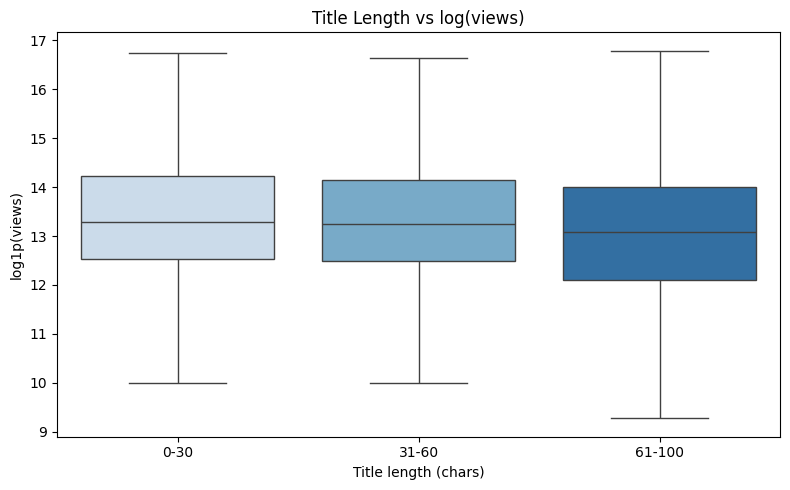

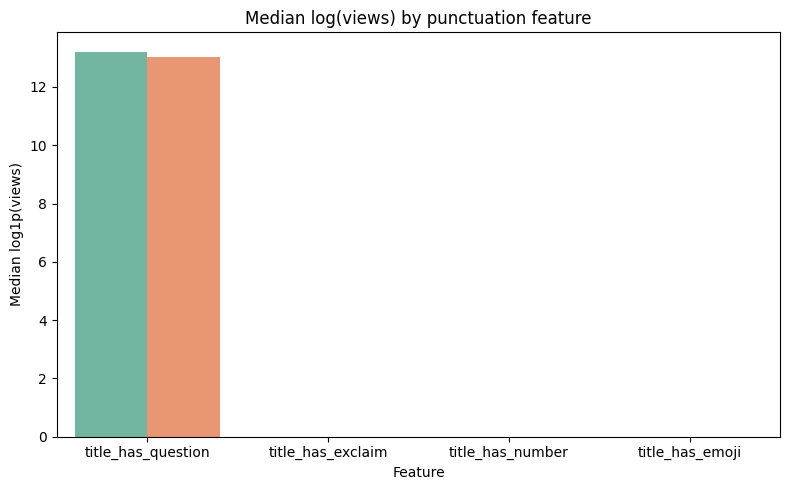

C:\Users\akato\AppData\Local\Temp\ipykernel_9712\2282912365.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="sent_title_bucket", y="log_views", data=sent_summary, palette="coolwarm")


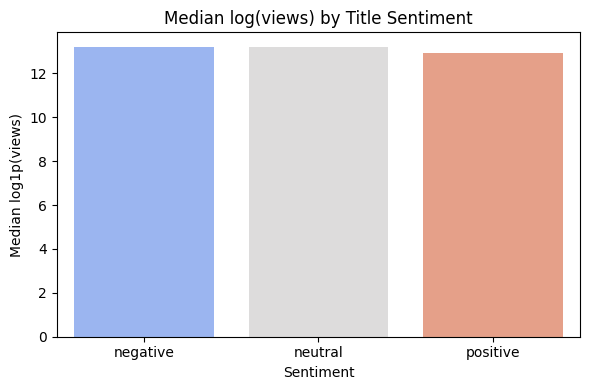

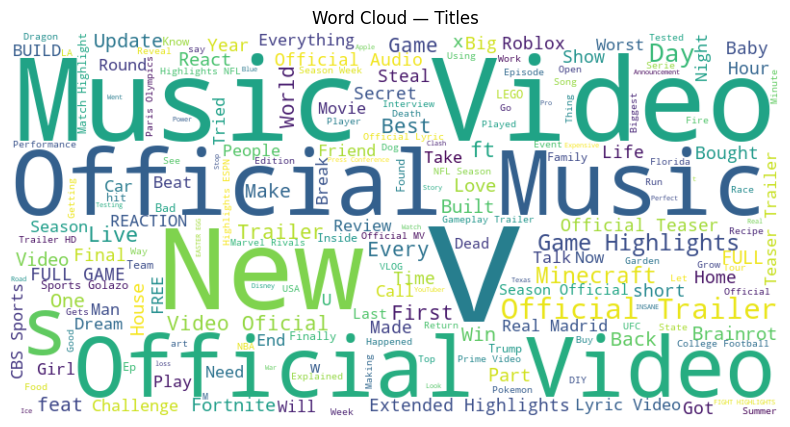

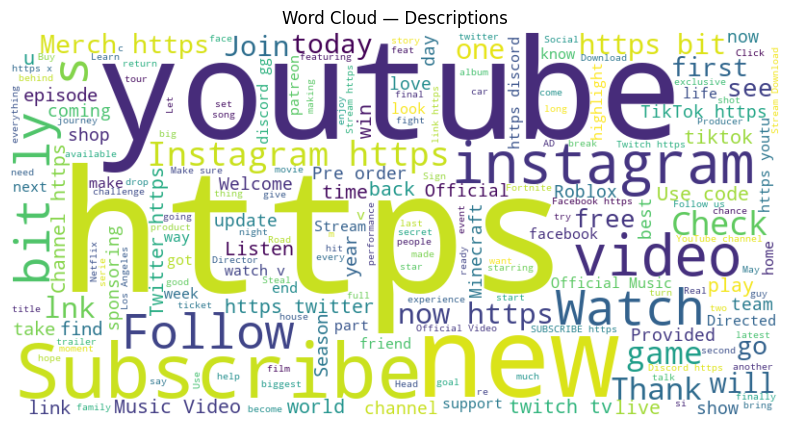

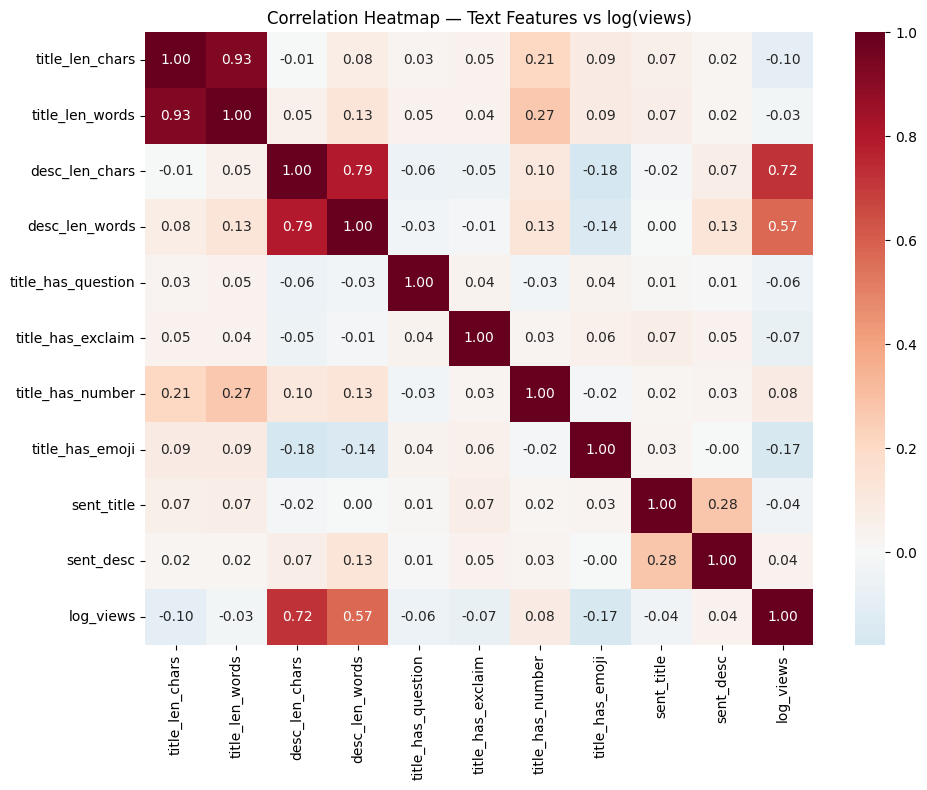


[INFO] Step 3.5 visuals saved to ./out_step3_5/


In [26]:
# STEP 3.5 — Visualizations of Title & Description Features

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# ---------- 0) Load enriched dataset ----------
PATH = "./youtube_step3_sentiment.csv"
df = pd.read_csv(PATH, low_memory=False, parse_dates=["published_at"])

os.makedirs("./out_step3_5", exist_ok=True)

# Ensure numeric target
df["log_views"] = np.log1p(df["views"].astype(float))

# ---------- 1) Title length vs Views ----------
df["title_len_bin"] = pd.cut(df["title_len_chars"], bins=[0,30,60,100], labels=["0-30","31-60","61-100"])

plt.figure(figsize=(8,5))
sns.boxplot(x="title_len_bin", y="log_views", data=df, showfliers=False, palette="Blues")
plt.title("Title Length vs log(views)")
plt.xlabel("Title length (chars)")
plt.ylabel("log1p(views)")
plt.tight_layout()
plt.savefig("./out_step3_5/fig_title_length_boxplot.png", dpi=150)
plt.show()

# ---------- 2) Punctuation usage vs Views ----------
punct_features = ["title_has_question","title_has_exclaim","title_has_number","title_has_emoji"]

punct_summary = []
for f in punct_features:
    g = df.groupby(f)["log_views"].median().reset_index()
    g["feature"] = f
    punct_summary.append(g)
punct_summary = pd.concat(punct_summary)

plt.figure(figsize=(8,5))
sns.barplot(x="feature", y="log_views", hue=punct_features[0], data=punct_summary, palette="Set2")
plt.title("Median log(views) by punctuation feature")
plt.xlabel("Feature")
plt.ylabel("Median log1p(views)")
plt.legend([],[],frameon=False)
plt.tight_layout()
plt.savefig("./out_step3_5/fig_punct_vs_views.png", dpi=150)
plt.show()

# ---------- 3) Sentiment vs Views ----------
sent_summary = df.groupby("sent_title_bucket")["log_views"].median().reset_index()

plt.figure(figsize=(6,4))
sns.barplot(x="sent_title_bucket", y="log_views", data=sent_summary, palette="coolwarm")
plt.title("Median log(views) by Title Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Median log1p(views)")
plt.tight_layout()
plt.savefig("./out_step3_5/fig_sentiment_vs_views.png", dpi=150)
plt.show()

# ---------- 4) Word Clouds ----------
title_text = " ".join(str(t) for t in df["title"].dropna())
desc_text  = " ".join(str(t) for t in df["description"].dropna())

wc_title = WordCloud(width=800, height=400, background_color="white").generate(title_text)
wc_desc  = WordCloud(width=800, height=400, background_color="white").generate(desc_text)

plt.figure(figsize=(10,5))
plt.imshow(wc_title, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud — Titles")
plt.savefig("./out_step3_5/fig_wordcloud_titles.png", dpi=150)
plt.show()

plt.figure(figsize=(10,5))
plt.imshow(wc_desc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud — Descriptions")
plt.savefig("./out_step3_5/fig_wordcloud_desc.png", dpi=150)
plt.show()

# ---------- 6) Correlation Heatmap ----------
corr_features = [
    "title_len_chars","title_len_words","desc_len_chars","desc_len_words",
    "title_has_question","title_has_exclaim","title_has_number","title_has_emoji",
    "sent_title","sent_desc","log_views"
]
corr_df = df[corr_features].copy()
corr = corr_df.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="RdBu_r", center=0)
plt.title("Correlation Heatmap — Text Features vs log(views)")
plt.tight_layout()
plt.savefig("./out_step3_5/fig_corr_heatmap.png", dpi=150)
plt.show()

print("\n[INFO] Step 3.5 visuals saved to ./out_step3_5/")
